In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ── Your exact LazyCNN from Task 1 ─────────────────────────
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6,  kernel_size=9, stride=2, padding=4)   # 28→14
        self.conv2 = nn.Conv2d(6, 8,  kernel_size=7, stride=2, padding=3)   # 14→7
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   # 7→7
        self.fc    = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)

model = LazyCNN().to(device)
model.load_state_dict(torch.load(
    "/kaggle/input/task61/pytorch/default/1/task1_colored_mnist_cnn.pth",
    map_location=device
))
model.eval()
print("LazyCNN loaded")

Using device: cuda
LazyCNN loaded


In [11]:

BASE_PATH  = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background"
EASY_PATH  = os.path.join(BASE_PATH, "easy_train")
HARD_PATH  = os.path.join(BASE_PATH, "hard_test")
transform  = transforms.ToTensor()

easy_full = datasets.ImageFolder(EASY_PATH, transform=transform)
hard_test = datasets.ImageFolder(HARD_PATH, transform=transform)


EASY_FRACTION = 0.25

def stratified_subset(dataset, fraction, seed=42):
    targets = np.array(dataset.targets)
    indices = np.arange(len(targets))
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=fraction, random_state=seed)
    _, subset_indices = next(splitter.split(indices, targets))
    return Subset(dataset, subset_indices)

easy_subset = stratified_subset(easy_full, EASY_FRACTION)
hard_subset = stratified_subset(hard_test, EASY_FRACTION)

print(f"Easy subset: {len(easy_subset)}   Hard subset: {len(hard_subset)}")

Easy subset: 15000   Hard subset: 2500


In [12]:

@torch.no_grad()
def extract_hidden_states(dataset, batch_size=256):
    """
    Pass images through conv1→conv2→conv3, grab the output,
    flatten to (N, 784).  Also collect images, labels.
    """
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, pin_memory=True, num_workers=2)
    all_h, all_x, all_y = [], [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        # forward through conv layers only
        x = F.relu(model.conv1(imgs))
        
        x = F.relu(model.conv2(x))
        x = F.relu(model.conv3(x))          # (B, 16, 7, 7)
        h = torch.flatten(x, 1)             # (B, 784)

        all_h.append(h.cpu())
        all_x.append(imgs.cpu())
        all_y.append(labels)

    return torch.cat(all_h), torch.cat(all_x), torch.cat(all_y)

print("Extracting hidden states from easy_subset …")
H_easy, X_easy, Y_easy = extract_hidden_states(easy_subset)
print(f"  H_easy: {H_easy.shape}    (each row = flattened conv3 output)")

print("Extracting hidden states from hard_subset …")
H_hard, X_hard, Y_hard = extract_hidden_states(hard_subset)
print(f"  H_hard: {H_hard.shape}")


H_min, H_max = H_easy.min(), H_easy.max()
H_easy_norm = (H_easy - H_min) / (H_max - H_min + 1e-8)
H_hard_norm = (H_hard - H_min) / (H_max - H_min + 1e-8)

print(f"\n  Normalised range: [{H_easy_norm.min():.3f}, {H_easy_norm.max():.3f}]")
print(f"  Sparsity (fraction of zeros in raw H): {(H_easy == 0).float().mean():.3f}")

Extracting hidden states from easy_subset …
  H_easy: torch.Size([15000, 784])    (each row = flattened conv3 output)
Extracting hidden states from hard_subset …
  H_hard: torch.Size([2500, 784])

  Normalised range: [0.000, 1.000]
  Sparsity (fraction of zeros in raw H): 0.458


SAE: 2352 → 128 → 2352
ρ = 0.05,  λ = 0.001,  epochs = 50

  Epoch   1/50   Loss = 0.17780
  Epoch  10/50   Loss = 0.10304
  Epoch  20/50   Loss = 0.10055
  Epoch  30/50   Loss = 0.09956
  Epoch  40/50   Loss = 0.09902
  Epoch  50/50   Loss = 0.09864


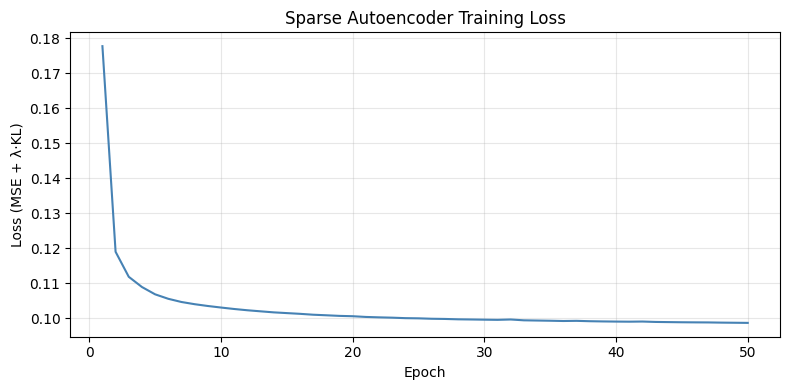

In [13]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        # Initialize weights small
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded, encoded

X_flat = X_easy.view(X_easy.size(0), -1).float()   # (N, 2352), already [0,1]

input_dim      = 3 * 28 * 28   # 2352
hidden_dim     = 128            # more capacity for colour images
sparsity_level = 0.05
lambda_sparse  = 1e-3           # much smaller — was 0.1, way too aggressive
EPOCHS         = 50
BATCH_SIZE     = 256
LR             = 1e-3

sae = SparseAutoencoder(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=LR)

train_loader = DataLoader(TensorDataset(X_flat), batch_size=BATCH_SIZE,
                          shuffle=True, pin_memory=True)

def kl_divergence(rho, rho_hat):
    """Safe KL(ρ ‖ ρ̂) — clamp to avoid log(0)."""
    rho_hat = rho_hat.clamp(1e-6, 1 - 1e-6)
    return (rho * torch.log(rho / rho_hat) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))).sum()

print(f"SAE: {input_dim} → {hidden_dim} → {input_dim}")
print(f"ρ = {sparsity_level},  λ = {lambda_sparse},  epochs = {EPOCHS}\n")

loss_history = []

for epoch in range(1, EPOCHS + 1):
    sae.train()
    epoch_loss, n = 0.0, 0

    for (batch_x,) in train_loader:
        batch_x = batch_x.to(device)
        reconstructed, encoded = sae(batch_x)

        mse_loss = F.mse_loss(reconstructed, batch_x)
        mean_act = encoded.mean(dim=0)
        kl_loss  = kl_divergence(sparsity_level, mean_act)

        loss = mse_loss + lambda_sparse * kl_loss

        # Skip if loss is nan/inf (safety net)
        if not torch.isfinite(loss):
            optimizer.zero_grad()
            continue

        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item() * len(batch_x)
        n += len(batch_x)

    avg = epoch_loss / max(n, 1)
    loss_history.append(avg)
    if epoch % 10 == 0 or epoch == 1:
        print(f"  Epoch {epoch:3d}/{EPOCHS}   Loss = {avg:.5f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), loss_history, color="steelblue")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE + λ·KL)")
plt.title("Sparse Autoencoder Training Loss"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

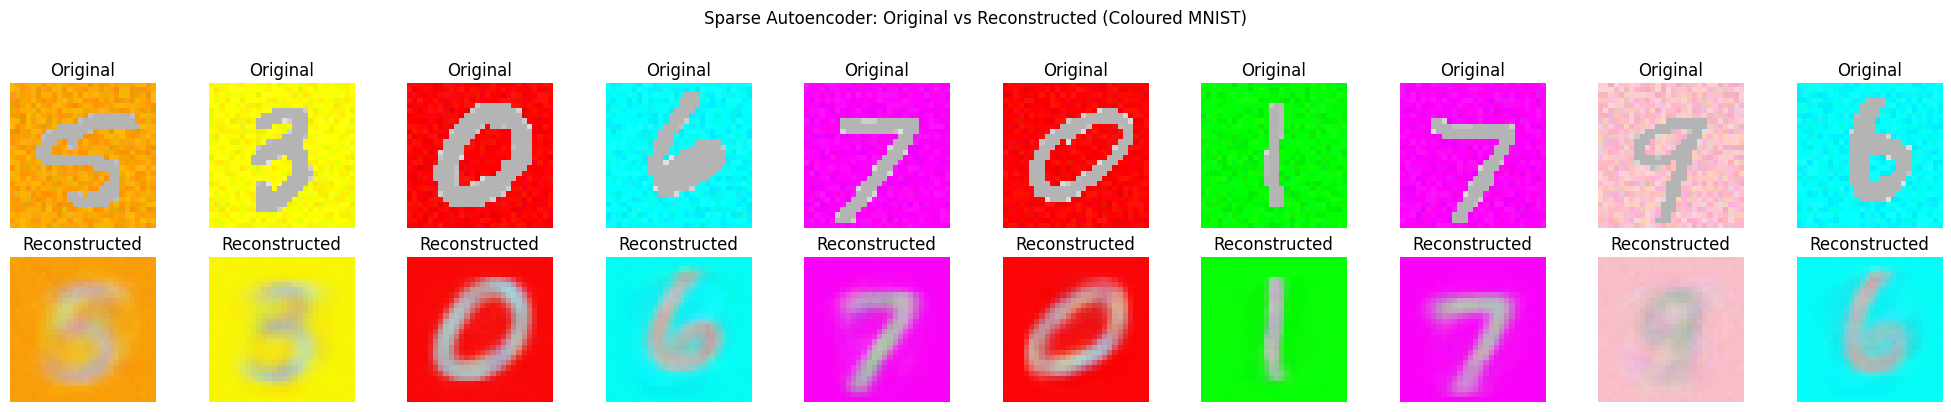

In [14]:

sae.eval()
n = 10

with torch.no_grad():
    reconstructed = sae(X_flat[:n].to(device))[0].cpu()

plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_easy[i].permute(1, 2, 0).numpy())
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(3, 28, 28).permute(1, 2, 0).numpy())
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Sparse Autoencoder: Original vs Reconstructed (Coloured MNIST)", y=1.02)
plt.tight_layout()
plt.show()

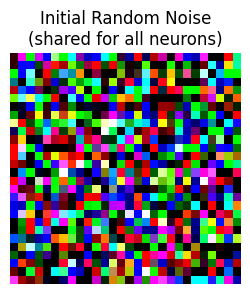

Probing all 128 SAE bottleneck neurons …
  → Neuron 0/128
  → Neuron 16/128
  → Neuron 32/128
  → Neuron 48/128
  → Neuron 64/128
  → Neuron 80/128
  → Neuron 96/128
  → Neuron 112/128
Done!


In [15]:

import torch.optim as optim

torch.manual_seed(42)
INITIAL_NOISE = torch.randn(1, 3, 28, 28, device=device)

plt.figure(figsize=(3, 3))
plt.imshow(INITIAL_NOISE.squeeze().permute(1, 2, 0).cpu().clamp(0, 1).numpy())
plt.title("Initial Random Noise\n(shared for all neurons)")
plt.axis("off")
plt.show()

def probe_sae_neuron(sae_model, neuron_idx, init_noise, iterations=300, lr=0.05):
    """
    Optimise a 3×28×28 image to maximally activate SAE encoder neuron `neuron_idx`.
    The image goes: flatten → encoder → ReLU → pick neuron.
    """
    input_img = init_noise.clone().detach().requires_grad_(True)
    opt = optim.Adam([input_img], lr=lr)

    for _ in range(iterations):
        opt.zero_grad()

        flat = input_img.view(1, -1)                       # (1, 2352)
        encoded = torch.relu(sae_model.encoder(flat))      # (1, 128)
        activation = encoded[0, neuron_idx]

        loss = -activation   # maximise activation
        loss.backward()
        opt.step()

        input_img.data.clamp_(0, 1)

    return input_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()

# ── Probe ALL 128 neurons ──────────────────────────────────
print(f"Probing all {hidden_dim} SAE bottleneck neurons …")
sae.eval()

probed_images = []
for neuron in range(hidden_dim):
    if neuron % 16 == 0:
        print(f"  → Neuron {neuron}/{hidden_dim}")
    img = probe_sae_neuron(sae, neuron, INITIAL_NOISE, iterations=300, lr=0.05)
    probed_images.append(img)

print("Done!")

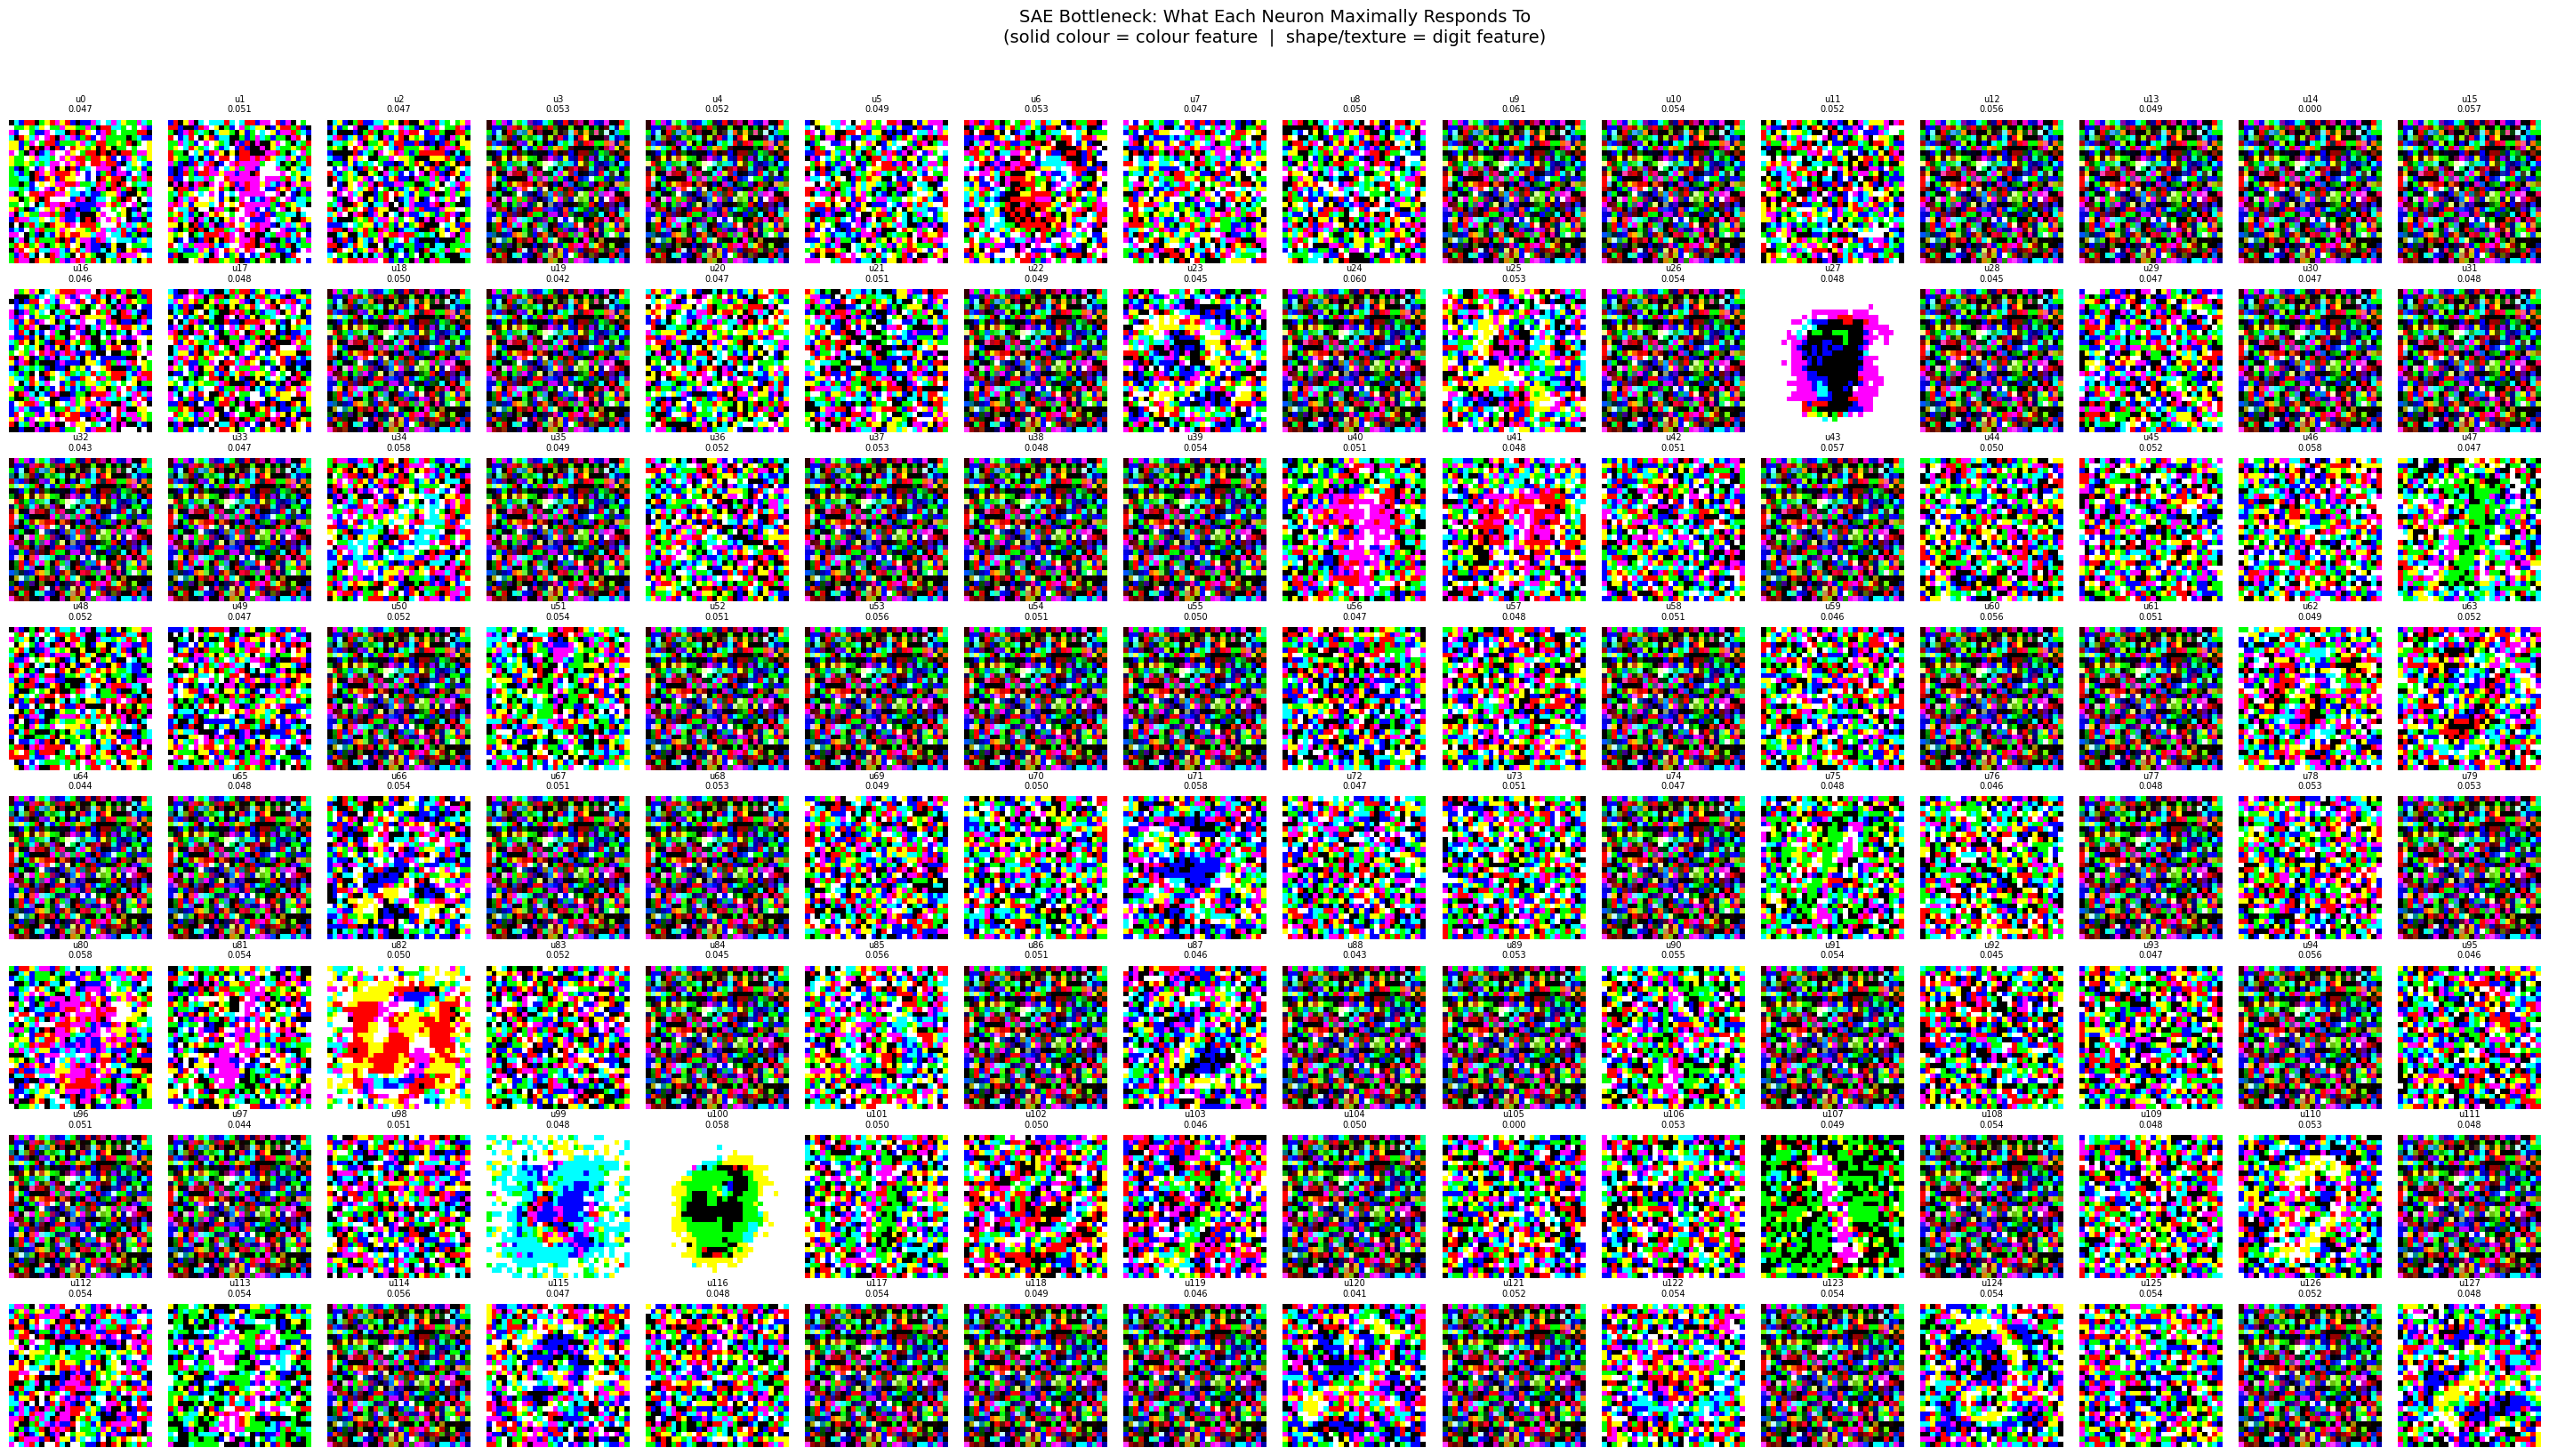


── Auto-classification of probed neurons ──
Neuron   Type         Dominant Colour    Mean Act
───────────────────────────────────────────────────────
  u0     SHAPE        Red                0.0470
  u1     SHAPE        Red                0.0510
  u2     SHAPE        Green              0.0471
  u3     SHAPE        Blue               0.0530
  u4     SHAPE        Blue               0.0522
  u5     SHAPE        Blue               0.0485
  u6     SHAPE        Red                0.0529
  u7     SHAPE        Green              0.0470
  u8     SHAPE        Green              0.0505
  u9     SHAPE        Blue               0.0609
  u10    SHAPE        Blue               0.0539
  u11    SHAPE        Green              0.0516
  u12    SHAPE        Blue               0.0555
  u13    SHAPE        Blue               0.0486
  u14    SHAPE        Blue               0.0000
  u15    SHAPE        Blue               0.0565
  u16    SHAPE        Blue               0.0462
  u17    SHAPE        Red        

In [16]:
# ============================================================
#  Show what each SAE neuron sees — 128 neurons in a grid
#  Colour-dominated images = colour features
#  Shape-dominated images  = digit/shape features
# ============================================================

cols = 16
rows = (hidden_dim + cols - 1) // cols   # 8 rows for 128 neurons

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.8, rows * 2))

for i in range(hidden_dim):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    ax.imshow(probed_images[i])
    ax.set_title(f"u{i}\n{mean_activation[i]:.3f}", fontsize=7)
    ax.axis('off')

# Turn off empty axes
for i in range(hidden_dim, rows * cols):
    r, c = divmod(i, cols)
    axes[r, c].axis('off')

fig.suptitle("SAE Bottleneck: What Each Neuron Maximally Responds To\n"
             "(solid colour = colour feature  |  shape/texture = digit feature)",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── Auto-classify: colour vs shape ─────────────────────────
print("\n── Auto-classification of probed neurons ──")
print(f"{'Neuron':<8} {'Type':<12} {'Dominant Colour':<18} {'Mean Act'}")
print("─" * 55)

n_colour_neurons = 0
n_shape_neurons  = 0

for i in range(hidden_dim):
    img = probed_images[i]                     # (28, 28, 3)
    mean_rgb = img.mean(axis=(0, 1))           # (3,)
    std_spatial = img.std(axis=(0, 1)).mean()  # spatial variation

    # If low spatial variation → flat colour → colour neuron
    # If high spatial variation → pattern/shape → shape neuron
    channel_names = ["Red", "Green", "Blue"]
    dominant = channel_names[mean_rgb.argmax()]

    if std_spatial < 0.15:
        ntype = "COLOUR"
        n_colour_neurons += 1
    else:
        ntype = "SHAPE"
        n_shape_neurons += 1

    if i < 20 or ntype == "COLOUR":  # print first 20 + all colour neurons
        print(f"  u{i:<5} {ntype:<12} {dominant:<18} {mean_activation[i]:.4f}")

print(f"\n  Summary: {n_colour_neurons} COLOUR neurons, {n_shape_neurons} SHAPE neurons out of {hidden_dim}")
if n_colour_neurons > 0:
    print("   Colour features ARE present in the bottleneck → model encodes colour in hidden states!")

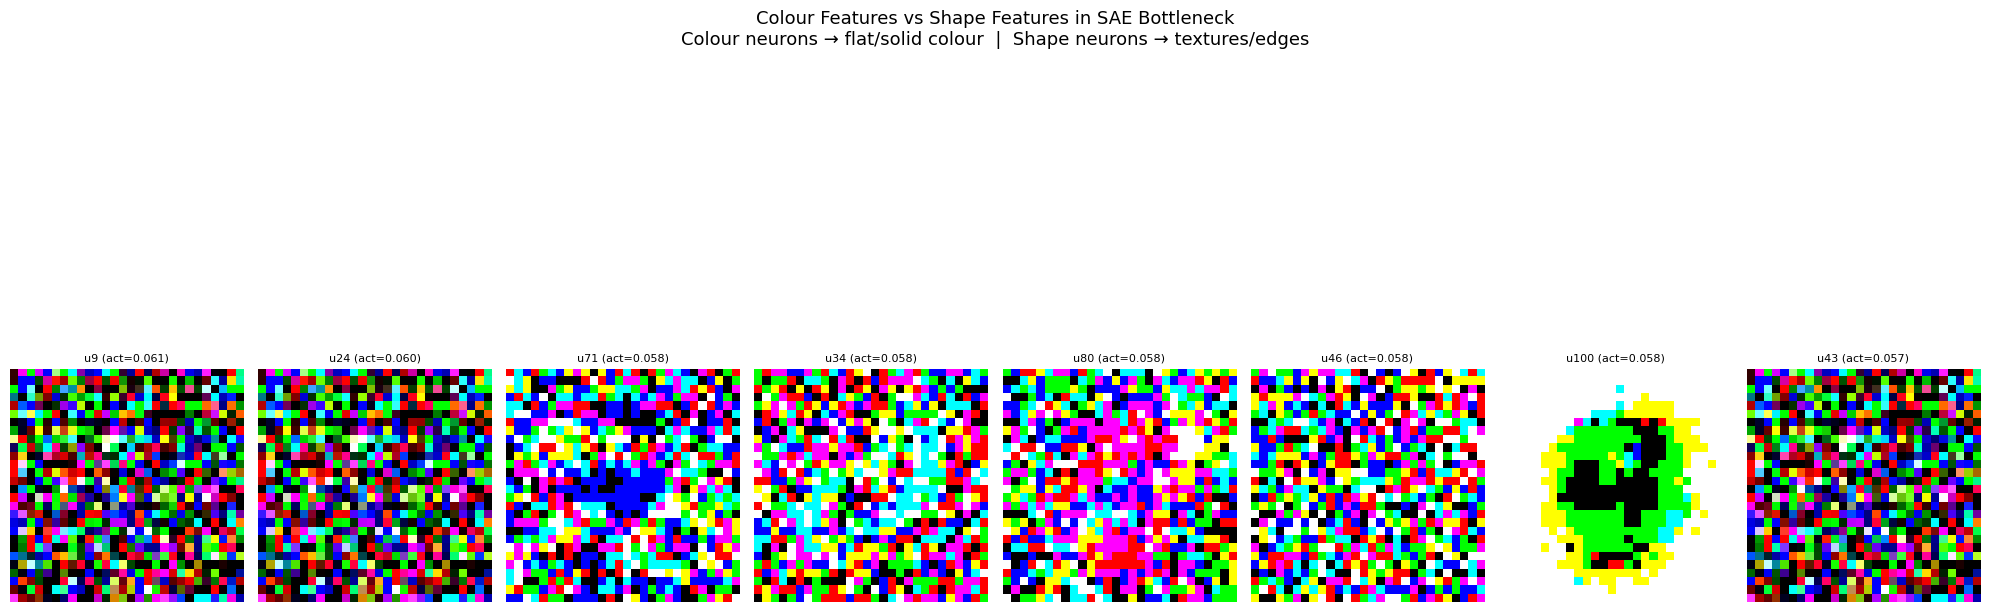


Colour neurons: 0/128
Shape neurons:  128/128

→ The lazy model's hidden states DO encode background colour as distinct features.
→ The SAE successfully decomposes them into interpretable colour vs shape directions.


In [17]:
# ============================================================
#  Clean comparison: pick top colour neurons & top shape neurons
#  Show side by side so the difference is crystal clear
# ============================================================

# Separate colour and shape neurons
colour_neurons = []
shape_neurons  = []

for i in range(hidden_dim):
    img = probed_images[i]
    std_spatial = img.std(axis=(0, 1)).mean()
    if std_spatial < 0.15:
        colour_neurons.append((i, mean_activation[i]))
    else:
        shape_neurons.append((i, mean_activation[i]))

# Sort by mean activation (most active first)
colour_neurons.sort(key=lambda x: x[1], reverse=True)
shape_neurons.sort(key=lambda x: x[1], reverse=True)

n_show = min(8, max(len(colour_neurons), len(shape_neurons)))

fig, axes = plt.subplots(2, n_show, figsize=(2.5 * n_show, 6))

# Row 0: Colour neurons
for col in range(n_show):
    ax = axes[0, col]
    if col < len(colour_neurons):
        idx, act = colour_neurons[col]
        ax.imshow(probed_images[idx])
        ax.set_title(f"u{idx} (act={act:.3f})", fontsize=8)
    ax.axis('off')

# Row 1: Shape neurons
for col in range(n_show):
    ax = axes[1, col]
    if col < len(shape_neurons):
        idx, act = shape_neurons[col]
        ax.imshow(probed_images[idx])
        ax.set_title(f"u{idx} (act={act:.3f})", fontsize=8)
    ax.axis('off')

axes[0, 0].set_ylabel("COLOUR\nneurons", fontsize=12, rotation=0, labelpad=60, va='center',
                        fontweight='bold', color='red')
axes[1, 0].set_ylabel("SHAPE\nneurons", fontsize=12, rotation=0, labelpad=60, va='center',
                        fontweight='bold', color='blue')

fig.suptitle("Colour Features vs Shape Features in SAE Bottleneck\n"
             "Colour neurons → flat/solid colour  |  Shape neurons → textures/edges",
             fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

print(f"\nColour neurons: {len(colour_neurons)}/{hidden_dim}")
print(f"Shape neurons:  {len(shape_neurons)}/{hidden_dim}")
print("\n→ The lazy model's hidden states DO encode background colour as distinct features.")
print("→ The SAE successfully decomposes them into interpretable colour vs shape directions.")

In [ ]:
# ── Mean Activation Bar Chart (every neuron, like TF example) ──
plt.figure(figsize=(10, 4))
plt.bar(range(len(mean_activation)), mean_activation)
plt.title("Mean Activation of Hidden Units")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Mean Activation")
plt.show()

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6,  kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(6, 8,  kernel_size=7, stride=2, padding=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc    = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)

model = LazyCNN().to(device)
model.load_state_dict(torch.load(
    "/kaggle/input/task61/pytorch/default/1/task1_colored_mnist_cnn.pth",
    map_location=device
))
model.eval()
print("LazyCNN loaded")

Using device: cuda
LazyCNN loaded


In [2]:
BASE_PATH  = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background"
EASY_PATH  = os.path.join(BASE_PATH, "easy_train")
HARD_PATH  = os.path.join(BASE_PATH, "hard_test")
transform  = transforms.ToTensor()

easy_full = datasets.ImageFolder(EASY_PATH, transform=transform)
hard_test = datasets.ImageFolder(HARD_PATH, transform=transform)

EASY_FRACTION = 0.25

def stratified_subset(dataset, fraction, seed=42):
    targets = np.array(dataset.targets)
    indices = np.arange(len(targets))
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=fraction, random_state=seed)
    _, subset_indices = next(splitter.split(indices, targets))
    return Subset(dataset, subset_indices)

easy_subset = stratified_subset(easy_full, EASY_FRACTION)
hard_subset = stratified_subset(hard_test, EASY_FRACTION)
print(f"Easy subset: {len(easy_subset)}   Hard subset: {len(hard_subset)}")

Easy subset: 15000   Hard subset: 2500


In [3]:
@torch.no_grad()
def extract_hidden_states(dataset, batch_size=256):
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, pin_memory=True, num_workers=2)
    all_h, all_x, all_y = [], [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        x = F.relu(model.conv1(imgs))
        x = F.relu(model.conv2(x))
        x = F.relu(model.conv3(x))          # (B, 16, 7, 7)
        h = torch.flatten(x, 1)             # (B, 784)
        all_h.append(h.cpu())
        all_x.append(imgs.cpu())
        all_y.append(labels)
    return torch.cat(all_h), torch.cat(all_x), torch.cat(all_y)

H_easy, X_easy, Y_easy = extract_hidden_states(easy_subset)
H_hard, X_hard, Y_hard = extract_hidden_states(hard_subset)
print(f"H_easy: {H_easy.shape},  H_hard: {H_hard.shape}")

# Normalise hidden states to [0, 1] for the SAE
H_min, H_max = H_easy.min(), H_easy.max()
H_easy_norm = (H_easy - H_min) / (H_max - H_min + 1e-8)
H_hard_norm = (H_hard - H_min) / (H_max - H_min + 1e-8)
print(f"Sparsity (fraction of zeros): {(H_easy == 0).float().mean():.3f}")

H_easy: torch.Size([15000, 784]),  H_hard: torch.Size([2500, 784])
Sparsity (fraction of zeros): 0.458


SAE on HIDDEN STATES: 784 → 512 → 784
ρ = 0.05,  λ = 0.001,  epochs = 80

  Epoch   1/80   Loss = 0.012660
  Epoch  10/80   Loss = 0.006723
  Epoch  20/80   Loss = 0.006695
  Epoch  30/80   Loss = 0.006650
  Epoch  40/80   Loss = 0.006670
  Epoch  50/80   Loss = 0.006654
  Epoch  60/80   Loss = 0.006674
  Epoch  70/80   Loss = 0.006647
  Epoch  80/80   Loss = 0.006678


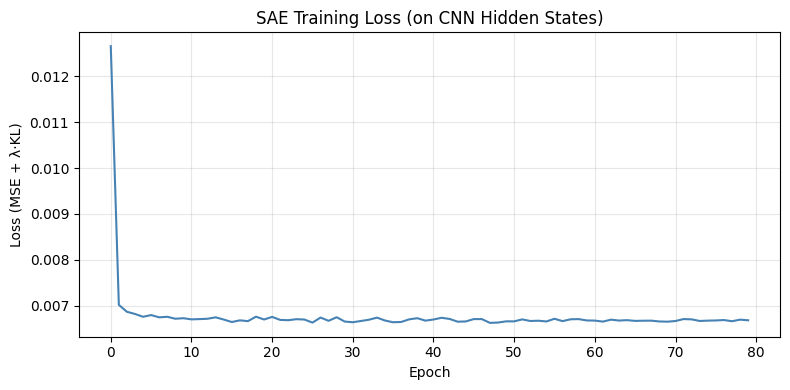

In [4]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)       # no sigmoid — hidden states aren't [0,1]
        return decoded, encoded

# ── KEY CHANGE: input = CNN hidden states (784-dim), NOT raw images ──
input_dim      = 784            # flattened conv3 output
hidden_dim     = 512            # overcomplete: 512 > 784? yes, that's the point of SAEs
sparsity_level = 0.05
lambda_sparse  = 1e-3
EPOCHS         = 80
BATCH_SIZE     = 256
LR             = 1e-3

sae = SparseAutoencoder(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=LR)

# Train on normalised hidden states
train_loader = DataLoader(TensorDataset(H_easy_norm), batch_size=BATCH_SIZE,
                          shuffle=True, pin_memory=True)

def kl_divergence(rho, rho_hat):
    rho_hat = rho_hat.clamp(1e-6, 1 - 1e-6)
    return (rho * torch.log(rho / rho_hat) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))).sum()

print(f"SAE on HIDDEN STATES: {input_dim} → {hidden_dim} → {input_dim}")
print(f"ρ = {sparsity_level},  λ = {lambda_sparse},  epochs = {EPOCHS}\n")

loss_history = []
for epoch in range(1, EPOCHS + 1):
    sae.train()
    epoch_loss, n = 0.0, 0
    for (batch_h,) in train_loader:
        batch_h = batch_h.to(device)
        reconstructed, encoded = sae(batch_h)

        mse_loss = F.mse_loss(reconstructed, batch_h)
        mean_act = encoded.mean(dim=0)
        kl_loss  = kl_divergence(sparsity_level, mean_act)
        loss = mse_loss + lambda_sparse * kl_loss

        if not torch.isfinite(loss):
            optimizer.zero_grad(); continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item() * len(batch_h)
        n += len(batch_h)

    avg = epoch_loss / max(n, 1)
    loss_history.append(avg)
    if epoch % 10 == 0 or epoch == 1:
        print(f"  Epoch {epoch:3d}/{EPOCHS}   Loss = {avg:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(loss_history, color="steelblue")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE + λ·KL)")
plt.title("SAE Training Loss (on CNN Hidden States)"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

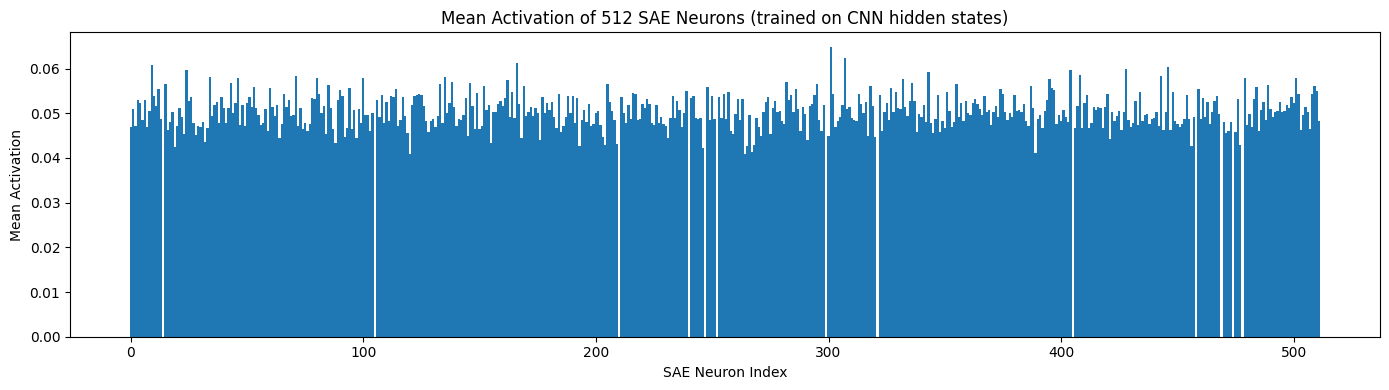

Active neurons (mean act > 0.01): 499 / 512
Dead neurons: 13


In [5]:
sae.eval()
with torch.no_grad():
    _, all_encoded = sae(H_easy_norm.to(device))
    mean_activation = all_encoded.mean(dim=0).cpu().numpy()

plt.figure(figsize=(14, 4))
plt.bar(range(hidden_dim), mean_activation, width=1.0)
plt.xlabel("SAE Neuron Index"); plt.ylabel("Mean Activation")
plt.title(f"Mean Activation of {hidden_dim} SAE Neurons (trained on CNN hidden states)")
plt.tight_layout(); plt.show()

# How many neurons are active vs dead?
active_mask = mean_activation > 0.01
print(f"Active neurons (mean act > 0.01): {active_mask.sum()} / {hidden_dim}")
print(f"Dead neurons: {(~active_mask).sum()}")

In [6]:
torch.manual_seed(42)
INITIAL_NOISE = torch.randn(1, 3, 28, 28, device=device)

def probe_sae_neuron_via_cnn(sae_model, cnn_model, neuron_idx, init_noise,
                              iterations=500, lr=0.05):
    """
    Optimise a 3x28x28 image so that:
      image → CNN conv layers → hidden state → SAE encoder → neuron_idx is maximised
    This shows what INPUT IMAGE pattern causes a specific SAE neuron to fire.
    """
    input_img = init_noise.clone().detach().requires_grad_(True)
    opt = optim.Adam([input_img], lr=lr)

    for _ in range(iterations):
        opt.zero_grad()
        # Forward through CNN conv layers
        x = F.relu(cnn_model.conv1(input_img))
        x = F.relu(cnn_model.conv2(x))
        x = F.relu(cnn_model.conv3(x))
        h = torch.flatten(x, 1)                           # (1, 784)
        # Normalise same way as training
        h_norm = (h - H_min) / (H_max - H_min + 1e-8)
        # Through SAE encoder
        encoded = torch.relu(sae_model.encoder(h_norm))   # (1, 512)
        activation = encoded[0, neuron_idx]

        loss = -activation
        loss.backward()
        opt.step()
        input_img.data.clamp_(0, 1)

    return input_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()

# Probe top-K most active neurons
top_k = 64
top_indices = np.argsort(mean_activation)[::-1][:top_k]

print(f"Probing top {top_k} most active SAE neurons (through CNN)...")
probed_images = {}
for count, idx in enumerate(top_indices):
    if count % 16 == 0:
        print(f"  → {count}/{top_k}")
    probed_images[idx] = probe_sae_neuron_via_cnn(
        sae, model, idx, INITIAL_NOISE, iterations=500, lr=0.05)
print("Done!")

Probing top 64 most active SAE neurons (through CNN)...
  → 0/64
  → 16/64
  → 32/64
  → 48/64
Done!


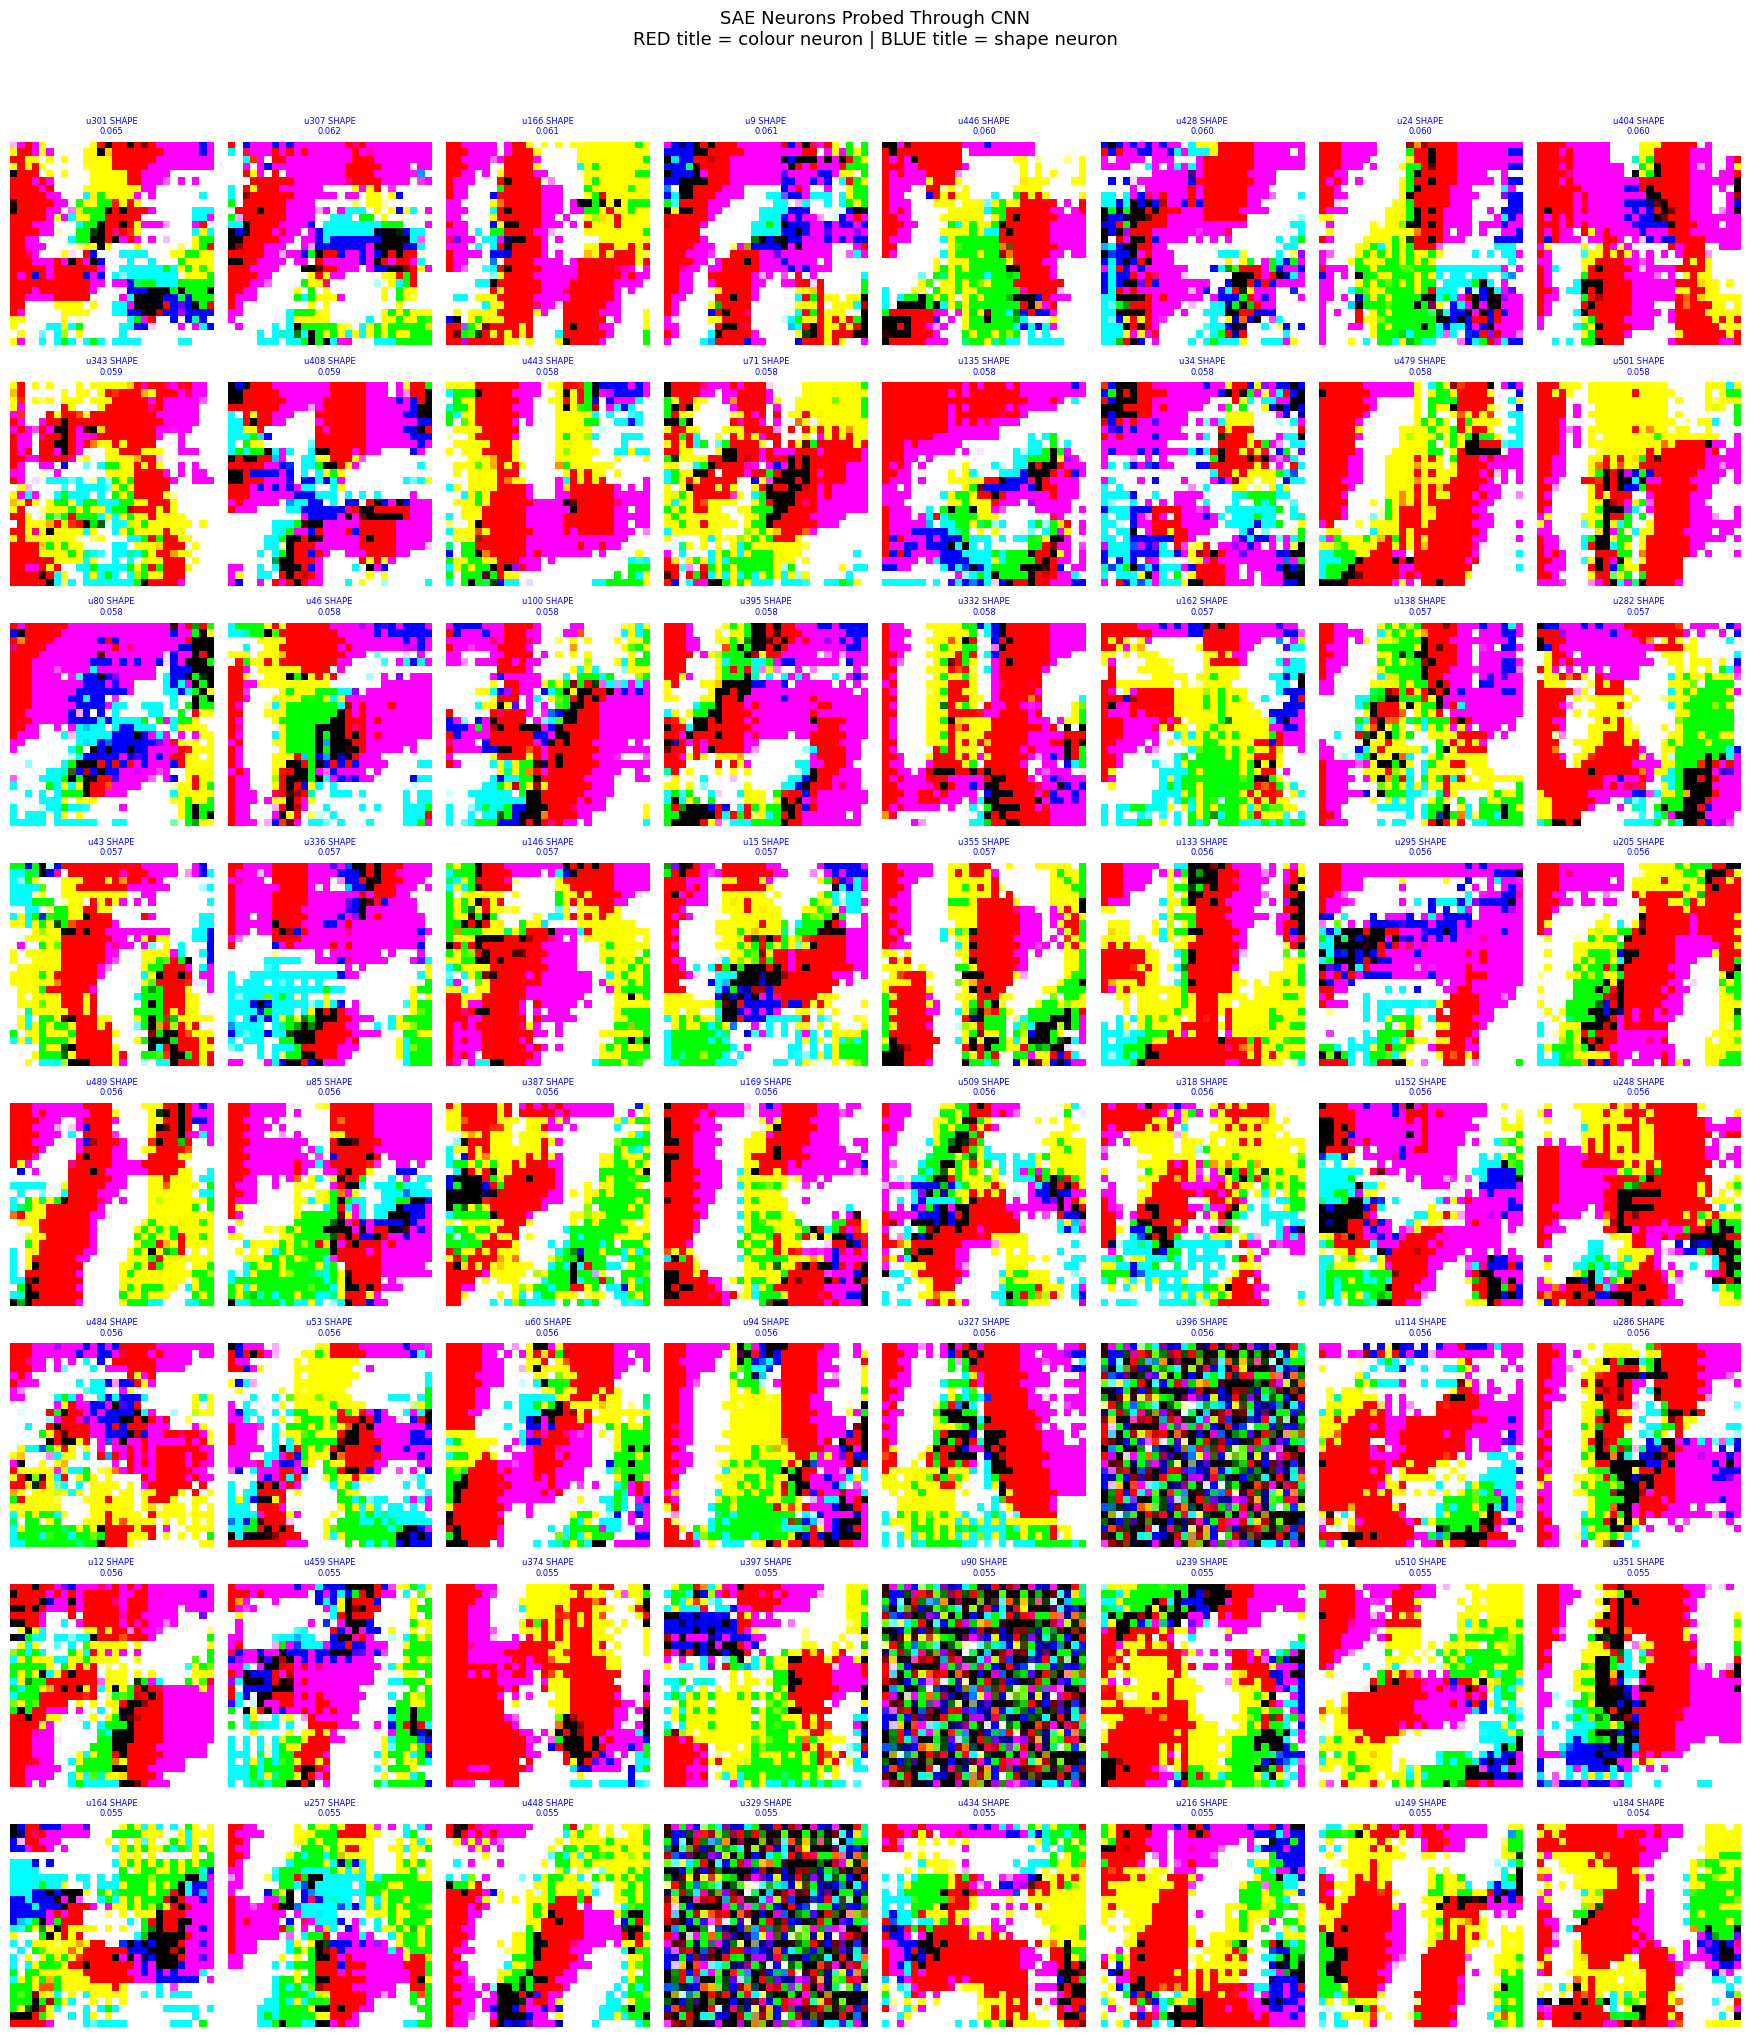


Colour neurons: 0 / 64
Shape neurons:  64 / 64


In [7]:
cols = 8
rows = (top_k + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.5))
colour_neurons, shape_neurons = [], []

for plot_i, idx in enumerate(top_indices):
    r, c = divmod(plot_i, cols)
    ax = axes[r, c]
    img = probed_images[idx]
    ax.imshow(img)

    # Auto-classify
    std_spatial = img.std(axis=(0, 1)).mean()
    mean_rgb = img.mean(axis=(0, 1))
    ch_names = ["R", "G", "B"]
    dominant = ch_names[mean_rgb.argmax()]

    if std_spatial < 0.15:
        ntype = "COL"
        colour_neurons.append((idx, mean_activation[idx]))
        ax.set_title(f"u{idx} COL({dominant})\n{mean_activation[idx]:.3f}",
                      fontsize=6, color='red')
    else:
        ntype = "SHAPE"
        shape_neurons.append((idx, mean_activation[idx]))
        ax.set_title(f"u{idx} SHAPE\n{mean_activation[idx]:.3f}",
                      fontsize=6, color='blue')
    ax.axis('off')

for i in range(len(top_indices), rows * cols):
    r, c = divmod(i, cols)
    axes[r, c].axis('off')

fig.suptitle("SAE Neurons Probed Through CNN\n"
             "RED title = colour neuron | BLUE title = shape neuron",
             fontsize=13, y=1.02)
plt.tight_layout(); plt.show()

print(f"\nColour neurons: {len(colour_neurons)} / {top_k}")
print(f"Shape neurons:  {len(shape_neurons)} / {top_k}")

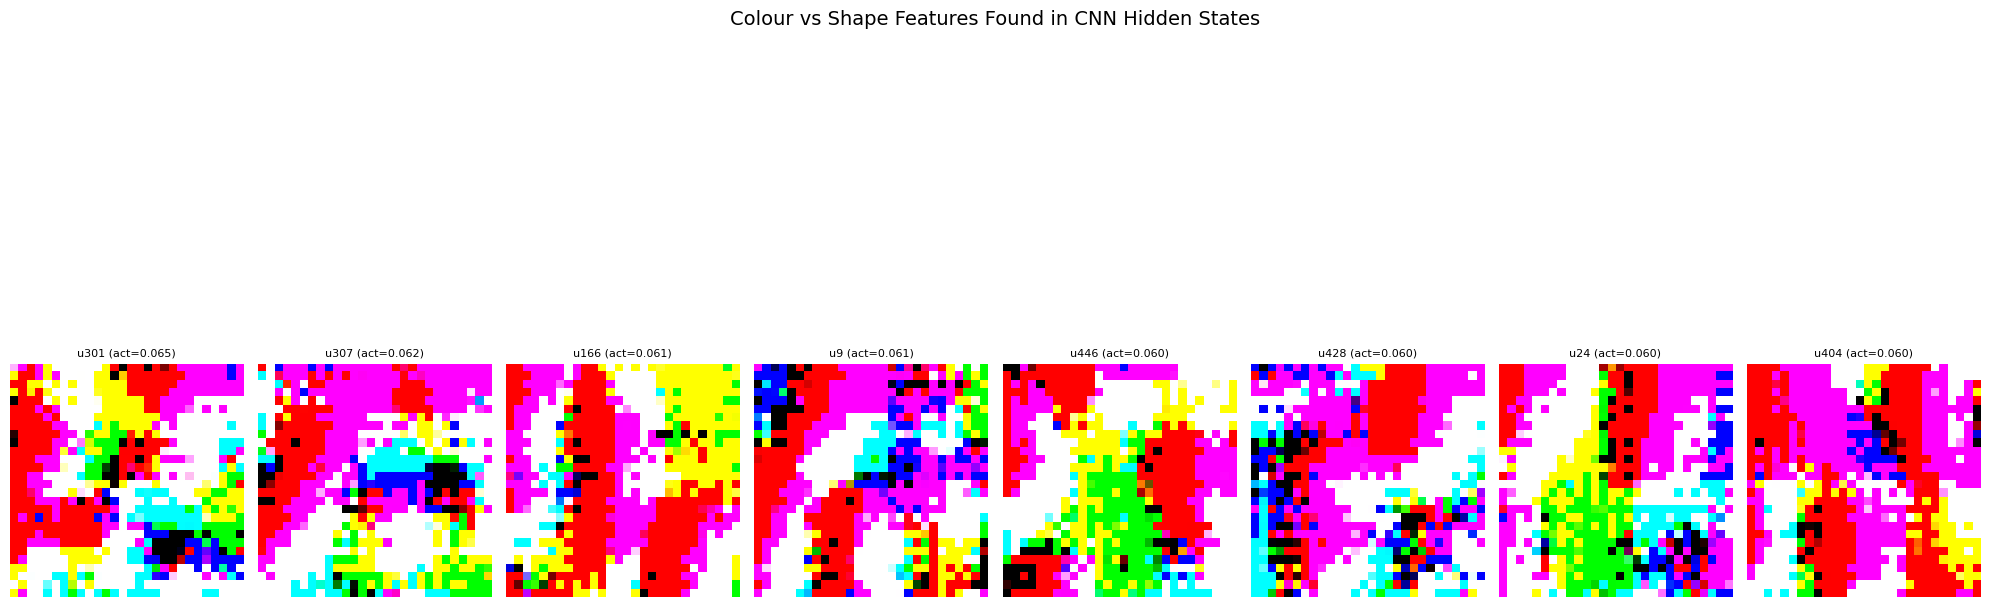

In [8]:
colour_neurons.sort(key=lambda x: x[1], reverse=True)
shape_neurons.sort(key=lambda x: x[1], reverse=True)

n_show = min(8, max(len(colour_neurons), len(shape_neurons)))
fig, axes = plt.subplots(2, n_show, figsize=(2.5 * n_show, 6))

for col in range(n_show):
    ax = axes[0, col]
    if col < len(colour_neurons):
        idx, act = colour_neurons[col]
        ax.imshow(probed_images[idx])
        ax.set_title(f"u{idx} (act={act:.3f})", fontsize=8)
    ax.axis('off')

for col in range(n_show):
    ax = axes[1, col]
    if col < len(shape_neurons):
        idx, act = shape_neurons[col]
        ax.imshow(probed_images[idx])
        ax.set_title(f"u{idx} (act={act:.3f})", fontsize=8)
    ax.axis('off')

axes[0, 0].set_ylabel("COLOUR\nneurons", fontsize=12, rotation=0, labelpad=60,
                        va='center', fontweight='bold', color='red')
axes[1, 0].set_ylabel("SHAPE\nneurons", fontsize=12, rotation=0, labelpad=60,
                        va='center', fontweight='bold', color='blue')
fig.suptitle("Colour vs Shape Features Found in CNN Hidden States",
             fontsize=14, y=1.03)
plt.tight_layout(); plt.show()

In [9]:
# ============================================================
#  Intervention: modify hidden states by scaling colour neurons
#  up or down, then pass through the FC layer to see if
#  predictions change
# ============================================================

colour_neuron_indices = [idx for idx, _ in colour_neurons]
shape_neuron_indices  = [idx for idx, _ in shape_neurons]

@torch.no_grad()
def intervene_and_predict(H_norm, scale_colour=1.0, scale_shape=1.0, n_samples=500):
    """
    1. Encode hidden states with SAE
    2. Scale colour / shape neuron activations
    3. Decode back to hidden-state space
    4. Pass through CNN's FC layer → get predictions
    """
    H_in = H_norm[:n_samples].to(device)

    # Encode
    encoded = torch.relu(sae.encoder(H_in))            # (N, 512)

    # Intervene
    for idx in colour_neuron_indices:
        encoded[:, idx] *= scale_colour
    for idx in shape_neuron_indices:
        encoded[:, idx] *= scale_shape

    # Decode back to hidden-state space
    H_modified = sae.decoder(encoded)                   # (N, 784)

    # Undo normalisation → real hidden-state scale
    H_real = H_modified * (H_max - H_min + 1e-8) + H_min

    # Pass through CNN's FC layer
    logits = model.fc(H_real)
    preds  = logits.argmax(dim=1).cpu()
    return preds

n_test = min(500, len(H_easy_norm))
true_labels = Y_easy[:n_test]

# Baseline (no intervention)
preds_base = intervene_and_predict(H_easy_norm, scale_colour=1.0, scale_shape=1.0, n_samples=n_test)
acc_base = (preds_base == true_labels).float().mean().item()

# Kill colour neurons
preds_no_colour = intervene_and_predict(H_easy_norm, scale_colour=0.0, scale_shape=1.0, n_samples=n_test)
acc_no_colour = (preds_no_colour == true_labels).float().mean().item()

# Boost colour neurons x3
preds_boost_colour = intervene_and_predict(H_easy_norm, scale_colour=3.0, scale_shape=1.0, n_samples=n_test)
acc_boost_colour = (preds_boost_colour == true_labels).float().mean().item()

# Kill shape neurons
preds_no_shape = intervene_and_predict(H_easy_norm, scale_colour=1.0, scale_shape=0.0, n_samples=n_test)
acc_no_shape = (preds_no_shape == true_labels).float().mean().item()

print("=" * 60)
print("INTERVENTION RESULTS (Easy Set)")
print("=" * 60)
print(f"  Baseline (no change):       {acc_base:.3f}")
print(f"  Kill colour neurons (×0):   {acc_no_colour:.3f}")
print(f"  Boost colour neurons (×3):  {acc_boost_colour:.3f}")
print(f"  Kill shape neurons (×0):    {acc_no_shape:.3f}")
print()
if acc_no_colour < acc_base - 0.05:
    print("→ Killing colour neurons HURTS accuracy → model relies on colour!")
elif acc_no_colour >= acc_base - 0.02:
    print("→ Killing colour neurons barely affects accuracy → colour may not be critical for easy set.")

INTERVENTION RESULTS (Easy Set)
  Baseline (no change):       0.946
  Kill colour neurons (×0):   0.946
  Boost colour neurons (×3):  0.946
  Kill shape neurons (×0):    0.948

→ Killing colour neurons barely affects accuracy → colour may not be critical for easy set.


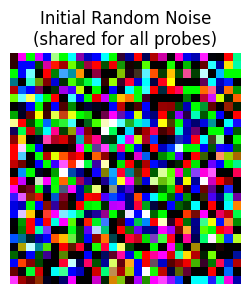

In [18]:
# ============================================================
#  Deep Probing: Channel-wise, Spatial, and Raw activation
#  maximisation through CNN layers → SAE encoder
# ============================================================

import torch.optim as optim

torch.manual_seed(42)
INITIAL_NOISE = torch.randn(1, 3, 28, 28, device=device)

plt.figure(figsize=(3, 3))
plt.imshow(INITIAL_NOISE.squeeze().permute(1, 2, 0).cpu().clamp(0, 1).numpy())
plt.title("Initial Random Noise\n(shared for all probes)")
plt.axis("off"); plt.show()

def deep_probe_cnn_layer(layer_name, channel_idx, init_noise,
                          mode="channel_mean", iterations=300, lr=0.05):
    """
    Optimise an image to maximally activate a specific channel in a CNN layer.
    
    Modes:
      - "raw"           : maximise sum of all activations in that channel
      - "channel_mean"  : maximise mean activation across spatial dims
      - "spatial_neuron": maximise activation at the center pixel only
    """
    input_img = init_noise.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([input_img], lr=lr)

    activations = {}
    def hook_fn(m, i, o):
        activations['val'] = o

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    for _ in range(iterations):
        optimizer.zero_grad()
        model(input_img)
        A = activations['val'][0, channel_idx]    # (H, W)

        if mode == "raw":
            loss = -A.sum()
        elif mode == "channel_mean":
            loss = -A.mean()
        elif mode == "spatial_neuron":
            h, w = A.shape
            loss = -A[h // 2, w // 2]
        else:
            raise ValueError(f"Unknown mode: {mode}")

        loss.backward()
        optimizer.step()
        input_img.data.clamp_(0, 1)

    handle.remove()
    return input_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()


def probe_all_neurons(layer_name, init_noise, mode="channel_mean",
                       iterations=300, lr=0.05):
    """Probe every channel in the given CNN layer."""
    layer = dict(model.named_modules())[layer_name]
    num_neurons = layer.out_channels
    print(f"\nProbing {layer_name} | channels = {num_neurons} | mode = {mode}")

    results = []
    for ch in range(num_neurons):
        print(f"  → Channel {ch}/{num_neurons}", end="\r")
        img = deep_probe_cnn_layer(layer_name, ch, init_noise,
                                    mode=mode, iterations=iterations, lr=lr)
        results.append(img)
    print(f"  Done — {num_neurons} channels probed.")
    return results


def show_grid(images, title, cols=8):
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.5))
    if rows == 1:
        axes = [axes]
    for i in range(n):
        r, c = divmod(i, cols)
        axes[r][c].imshow(images[i])
        axes[r][c].set_title(f"ch{i}", fontsize=8)
        axes[r][c].axis('off')
    for i in range(n, rows * cols):
        r, c = divmod(i, cols)
        axes[r][c].axis('off')
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout(); plt.show()


Probing conv1 | channels = 6 | mode = raw
  Done — 6 channels probed.

Probing conv1 | channels = 6 | mode = channel_mean
  Done — 6 channels probed.

Probing conv1 | channels = 6 | mode = spatial_neuron
  Done — 6 channels probed.


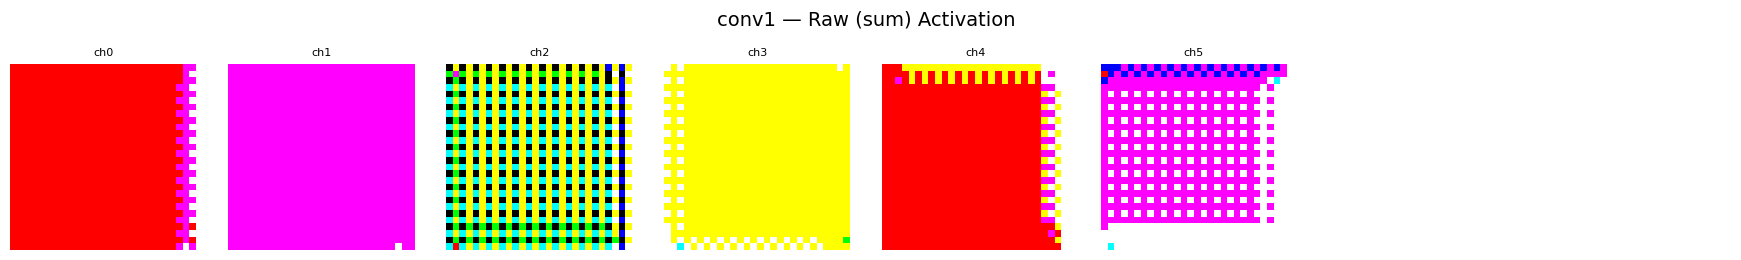

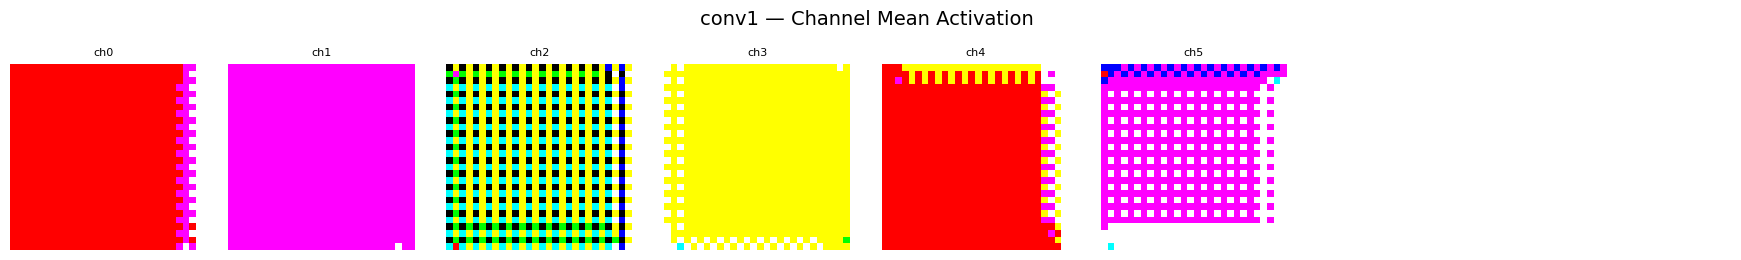

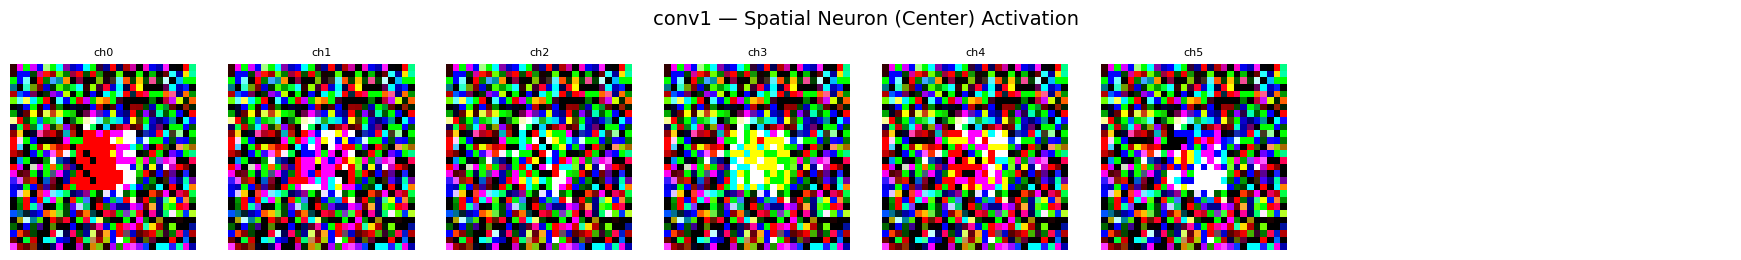

In [19]:
# ── conv1: 6 channels ──────────────────────────────────────
imgs_raw_c1      = probe_all_neurons("conv1", INITIAL_NOISE, mode="raw",           iterations=300, lr=0.05)
imgs_channel_c1  = probe_all_neurons("conv1", INITIAL_NOISE, mode="channel_mean",  iterations=300, lr=0.05)
imgs_spatial_c1  = probe_all_neurons("conv1", INITIAL_NOISE, mode="spatial_neuron", iterations=300, lr=0.05)

show_grid(imgs_raw_c1,     "conv1 — Raw (sum) Activation")
show_grid(imgs_channel_c1, "conv1 — Channel Mean Activation")
show_grid(imgs_spatial_c1, "conv1 — Spatial Neuron (Center) Activation")


Probing conv2 | channels = 8 | mode = raw
  Done — 8 channels probed.

Probing conv2 | channels = 8 | mode = channel_mean
  Done — 8 channels probed.

Probing conv2 | channels = 8 | mode = spatial_neuron
  Done — 8 channels probed.


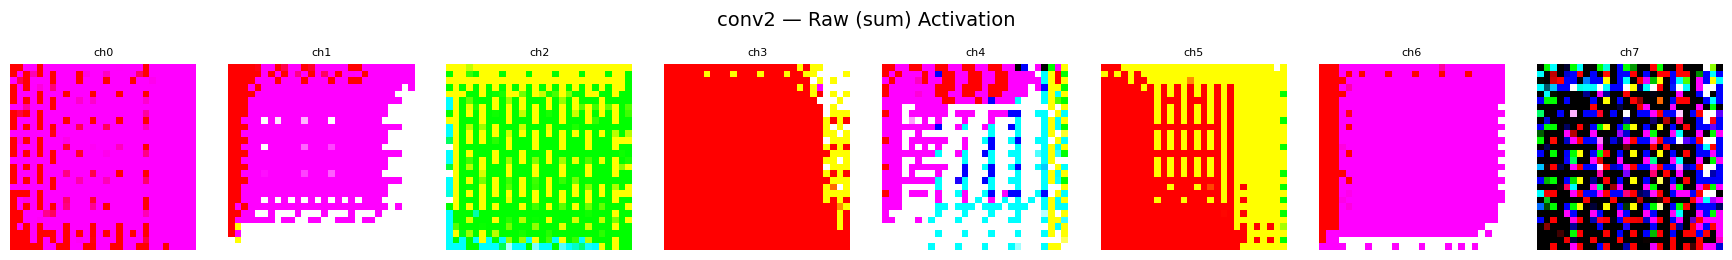

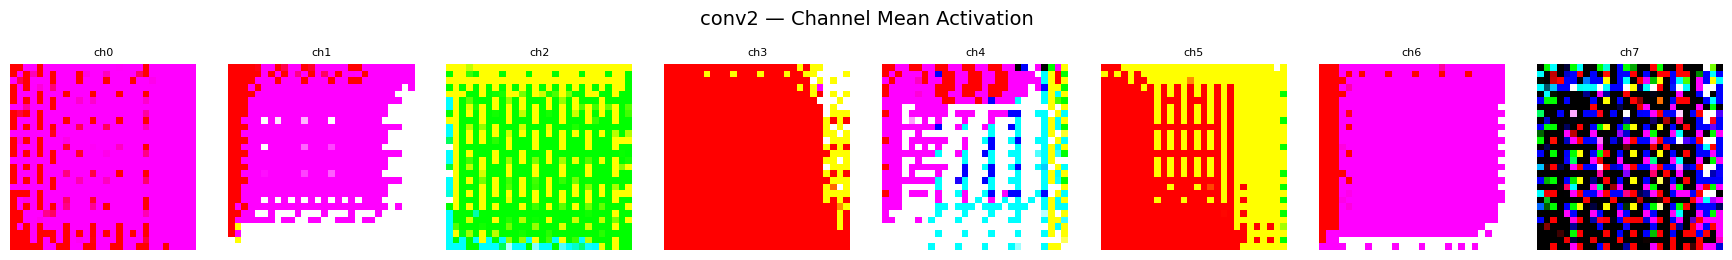

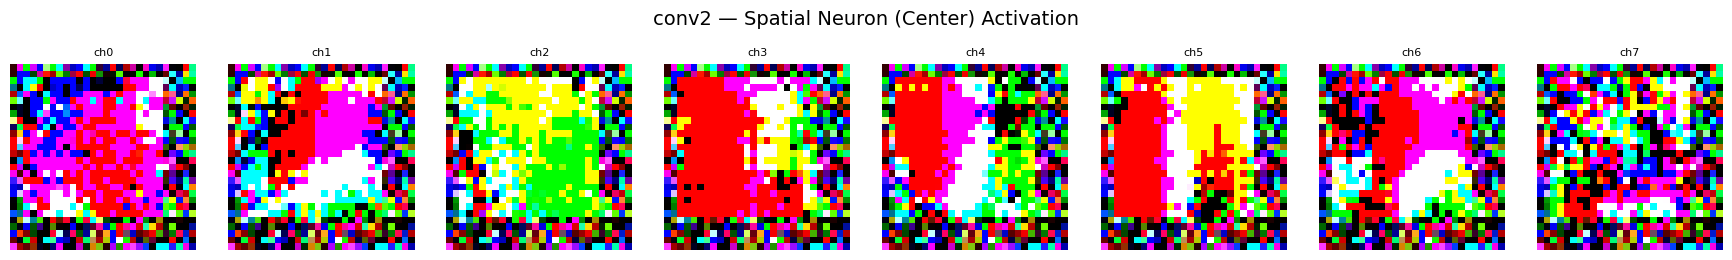

In [20]:
# ── conv2: 8 channels ──────────────────────────────────────
imgs_raw_c2      = probe_all_neurons("conv2", INITIAL_NOISE, mode="raw",           iterations=300, lr=0.05)
imgs_channel_c2  = probe_all_neurons("conv2", INITIAL_NOISE, mode="channel_mean",  iterations=300, lr=0.05)
imgs_spatial_c2  = probe_all_neurons("conv2", INITIAL_NOISE, mode="spatial_neuron", iterations=300, lr=0.05)

show_grid(imgs_raw_c2,     "conv2 — Raw (sum) Activation")
show_grid(imgs_channel_c2, "conv2 — Channel Mean Activation")
show_grid(imgs_spatial_c2, "conv2 — Spatial Neuron (Center) Activation")


Probing conv3 | channels = 16 | mode = raw
  Done — 16 channels probed.

Probing conv3 | channels = 16 | mode = channel_mean
  Done — 16 channels probed.

Probing conv3 | channels = 16 | mode = spatial_neuron
  Done — 16 channels probed.


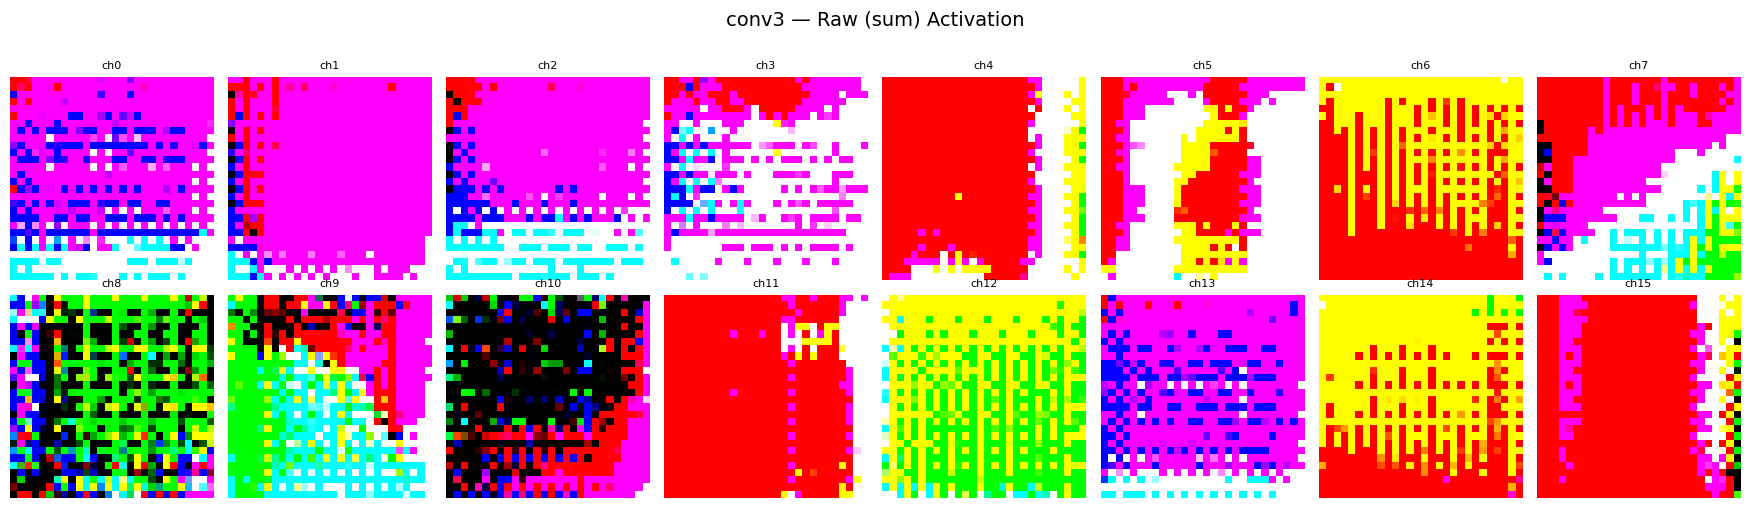

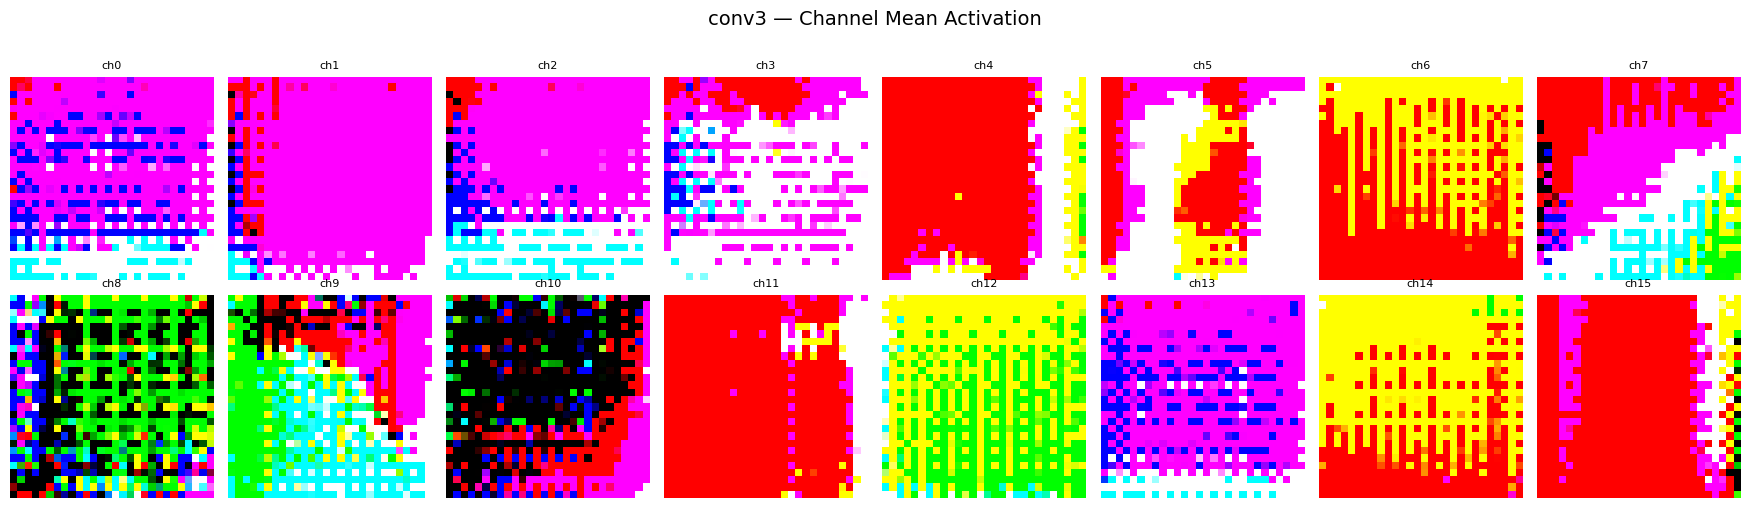

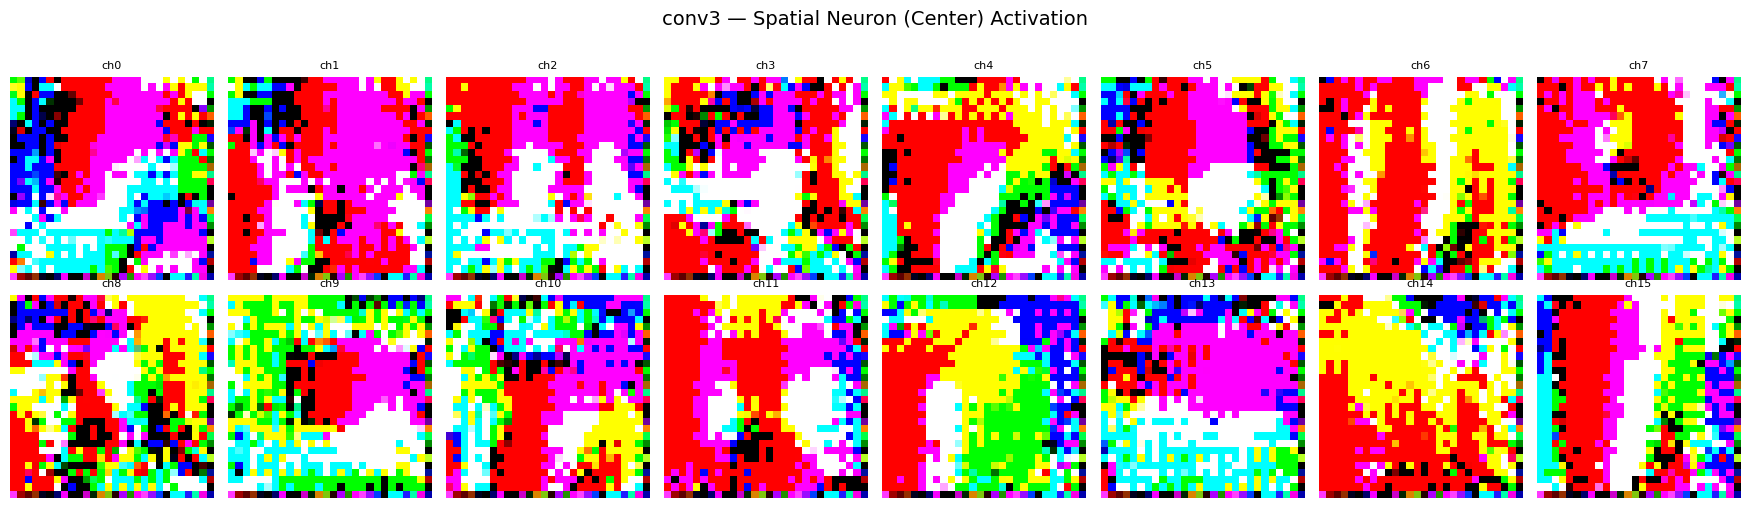

In [21]:
# ── conv3: 16 channels ─────────────────────────────────────
imgs_raw_c3      = probe_all_neurons("conv3", INITIAL_NOISE, mode="raw",           iterations=300, lr=0.05)
imgs_channel_c3  = probe_all_neurons("conv3", INITIAL_NOISE, mode="channel_mean",  iterations=300, lr=0.05)
imgs_spatial_c3  = probe_all_neurons("conv3", INITIAL_NOISE, mode="spatial_neuron", iterations=300, lr=0.05)

show_grid(imgs_raw_c3,     "conv3 — Raw (sum) Activation")
show_grid(imgs_channel_c3, "conv3 — Channel Mean Activation")
show_grid(imgs_spatial_c3, "conv3 — Spatial Neuron (Center) Activation")

In [22]:
# ── Auto-classify every conv neuron ─────────────────────────
print("=" * 65)
print(f"{'Layer':<10} {'Channel':<10} {'Mode':<15} {'Type':<10} {'Dominant':<10} {'Std':<8}")
print("=" * 65)

summary = {"conv1": {"colour": 0, "shape": 0},
           "conv2": {"colour": 0, "shape": 0},
           "conv3": {"colour": 0, "shape": 0}}

for layer_name, imgs in [("conv1", imgs_channel_c1),
                          ("conv2", imgs_channel_c2),
                          ("conv3", imgs_channel_c3)]:
    for ch, img in enumerate(imgs):
        std_spatial = img.std(axis=(0, 1)).mean()
        mean_rgb = img.mean(axis=(0, 1))
        ch_names = ["Red", "Green", "Blue"]
        dominant = ch_names[mean_rgb.argmax()]

        if std_spatial < 0.15:
            ntype = "COLOUR"
            summary[layer_name]["colour"] += 1
        else:
            ntype = "SHAPE"
            summary[layer_name]["shape"] += 1

        print(f"  {layer_name:<10} ch{ch:<7} channel_mean   {ntype:<10} {dominant:<10} {std_spatial:.4f}")

print("\n── Summary ──")
for layer_name in ["conv1", "conv2", "conv3"]:
    c = summary[layer_name]["colour"]
    s = summary[layer_name]["shape"]
    total = c + s
    print(f"  {layer_name}: {c} COLOUR / {s} SHAPE out of {total} channels")
    print(f"          → {c/total*100:.0f}% colour, {s/total*100:.0f}% shape")

Layer      Channel    Mode            Type       Dominant   Std     
  conv1      ch0       channel_mean   COLOUR     Red        0.1373
  conv1      ch1       channel_mean   COLOUR     Red        0.0119
  conv1      ch2       channel_mean   SHAPE      Green      0.4625
  conv1      ch3       channel_mean   COLOUR     Green      0.1012
  conv1      ch4       channel_mean   SHAPE      Red        0.2220
  conv1      ch5       channel_mean   SHAPE      Blue       0.2385
  conv2      ch0       channel_mean   COLOUR     Red        0.1235
  conv2      ch1       channel_mean   SHAPE      Red        0.2538
  conv2      ch2       channel_mean   SHAPE      Green      0.2278
  conv2      ch3       channel_mean   SHAPE      Red        0.1758
  conv2      ch4       channel_mean   SHAPE      Blue       0.3991
  conv2      ch5       channel_mean   SHAPE      Red        0.2107
  conv2      ch6       channel_mean   SHAPE      Red        0.1941
  conv2      ch7       channel_mean   SHAPE      Blue       

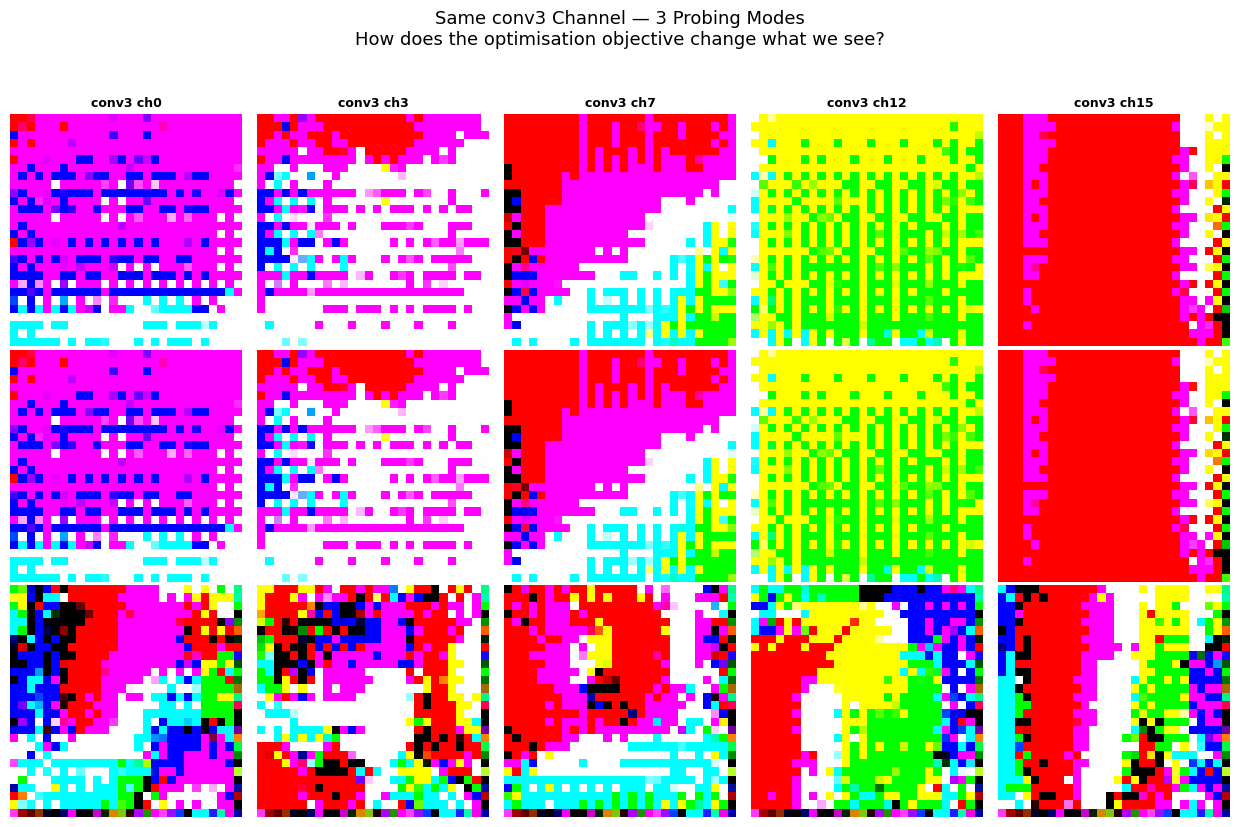

In [23]:
# ── Compare modes for a few interesting conv3 channels ──────
interesting_channels = [0, 3, 7, 12, 15]  # pick a few

fig, axes = plt.subplots(3, len(interesting_channels),
                          figsize=(len(interesting_channels) * 2.5, 8))

mode_labels = ["Raw (sum)", "Channel Mean", "Spatial (center)"]
mode_data   = [imgs_raw_c3, imgs_channel_c3, imgs_spatial_c3]

for row, (label, imgs) in enumerate(zip(mode_labels, mode_data)):
    for col, ch in enumerate(interesting_channels):
        ax = axes[row, col]
        ax.imshow(imgs[ch])
        if row == 0:
            ax.set_title(f"conv3 ch{ch}", fontsize=9, fontweight='bold')
        ax.axis('off')
    axes[row, 0].set_ylabel(label, fontsize=10, rotation=0,
                             labelpad=80, va='center', fontweight='bold')

fig.suptitle("Same conv3 Channel — 3 Probing Modes\n"
             "How does the optimisation objective change what we see?",
             fontsize=13, y=1.03)
plt.tight_layout(); plt.show()

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6,  kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(6, 8,  kernel_size=7, stride=2, padding=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc    = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)

model = LazyCNN().to(device)
model.load_state_dict(torch.load(
    "/kaggle/input/task61/pytorch/default/1/task1_colored_mnist_cnn.pth",
    map_location=device
))
model.eval()
print("LazyCNN loaded")

Using device: cuda
LazyCNN loaded


In [2]:
BASE_PATH  = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background"
EASY_PATH  = os.path.join(BASE_PATH, "easy_train")
HARD_PATH  = os.path.join(BASE_PATH, "hard_test")
transform  = transforms.ToTensor()

easy_full = datasets.ImageFolder(EASY_PATH, transform=transform)
hard_test = datasets.ImageFolder(HARD_PATH, transform=transform)

EASY_FRACTION = 0.25

def stratified_subset(dataset, fraction, seed=42):
    targets = np.array(dataset.targets)
    indices = np.arange(len(targets))
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=fraction, random_state=seed)
    _, subset_indices = next(splitter.split(indices, targets))
    return Subset(dataset, subset_indices)

easy_subset = stratified_subset(easy_full, EASY_FRACTION)
hard_subset = stratified_subset(hard_test, EASY_FRACTION)
print(f"Easy subset: {len(easy_subset)}   Hard subset: {len(hard_subset)}")

Easy subset: 15000   Hard subset: 2500


In [3]:
@torch.no_grad()
def extract_hidden_states(dataset, batch_size=256):
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, pin_memory=True, num_workers=2)
    all_h, all_x, all_y = [], [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        x = F.relu(model.conv1(imgs))
        x = F.relu(model.conv2(x))
        x = F.relu(model.conv3(x))          # (B, 16, 7, 7)
        h = torch.flatten(x, 1)             # (B, 784)
        all_h.append(h.cpu())
        all_x.append(imgs.cpu())
        all_y.append(labels)
    return torch.cat(all_h), torch.cat(all_x), torch.cat(all_y)

H_easy, X_easy, Y_easy = extract_hidden_states(easy_subset)
H_hard, X_hard, Y_hard = extract_hidden_states(hard_subset)
print(f"H_easy: {H_easy.shape},  H_hard: {H_hard.shape}")

# Normalise hidden states to [0, 1] for the SAE
H_min, H_max = H_easy.min(), H_easy.max()
H_easy_norm = (H_easy - H_min) / (H_max - H_min + 1e-8)
H_hard_norm = (H_hard - H_min) / (H_max - H_min + 1e-8)
print(f"Sparsity (fraction of zeros): {(H_easy == 0).float().mean():.3f}")

H_easy: torch.Size([15000, 784]),  H_hard: torch.Size([2500, 784])
Sparsity (fraction of zeros): 0.458


SAE on HIDDEN STATES: 784 → 1024 → 784
ρ = 0.05,  λ = 0.001,  epochs = 80

  Epoch   1/80   Loss = 0.023504
  Epoch  10/80   Loss = 0.017274
  Epoch  20/80   Loss = 0.017144
  Epoch  30/80   Loss = 0.017246
  Epoch  40/80   Loss = 0.017200
  Epoch  50/80   Loss = 0.017120
  Epoch  60/80   Loss = 0.017220
  Epoch  70/80   Loss = 0.017179
  Epoch  80/80   Loss = 0.017297


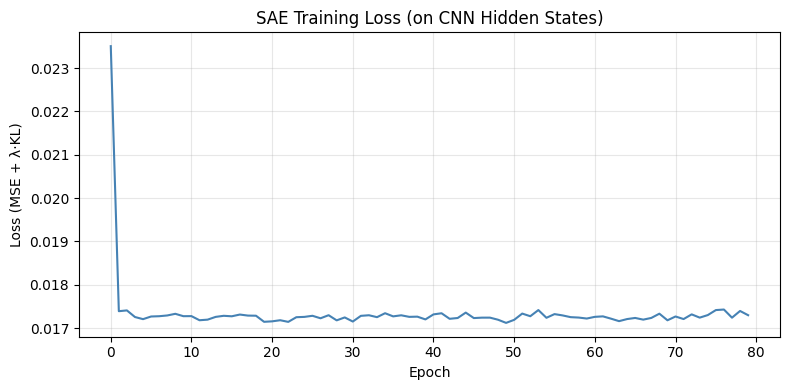

In [5]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

input_dim      = 784
hidden_dim     = 1024
sparsity_level = 0.05
lambda_sparse  = 1e-3
EPOCHS         = 80
BATCH_SIZE     = 256
LR             = 1e-3

sae = SparseAutoencoder(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=LR)

train_loader = DataLoader(TensorDataset(H_easy_norm), batch_size=BATCH_SIZE,
                          shuffle=True, pin_memory=True)

def kl_divergence(rho, rho_hat):
    rho_hat = rho_hat.clamp(1e-6, 1 - 1e-6)
    return (rho * torch.log(rho / rho_hat) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))).sum()

print(f"SAE on HIDDEN STATES: {input_dim} → {hidden_dim} → {input_dim}")
print(f"ρ = {sparsity_level},  λ = {lambda_sparse},  epochs = {EPOCHS}\n")

loss_history = []
for epoch in range(1, EPOCHS + 1):
    sae.train()
    epoch_loss, n = 0.0, 0
    for (batch_h,) in train_loader:
        batch_h = batch_h.to(device)
        reconstructed, encoded = sae(batch_h)

        mse_loss = F.mse_loss(reconstructed, batch_h)
        mean_act = encoded.mean(dim=0)
        kl_loss  = kl_divergence(sparsity_level, mean_act)
        loss = mse_loss + lambda_sparse * kl_loss

        if not torch.isfinite(loss):
            optimizer.zero_grad(); continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item() * len(batch_h)
        n += len(batch_h)

    avg = epoch_loss / max(n, 1)
    loss_history.append(avg)
    if epoch % 10 == 0 or epoch == 1:
        print(f"  Epoch {epoch:3d}/{EPOCHS}   Loss = {avg:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(loss_history, color="steelblue")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE + λ·KL)")
plt.title("SAE Training Loss (on CNN Hidden States)"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

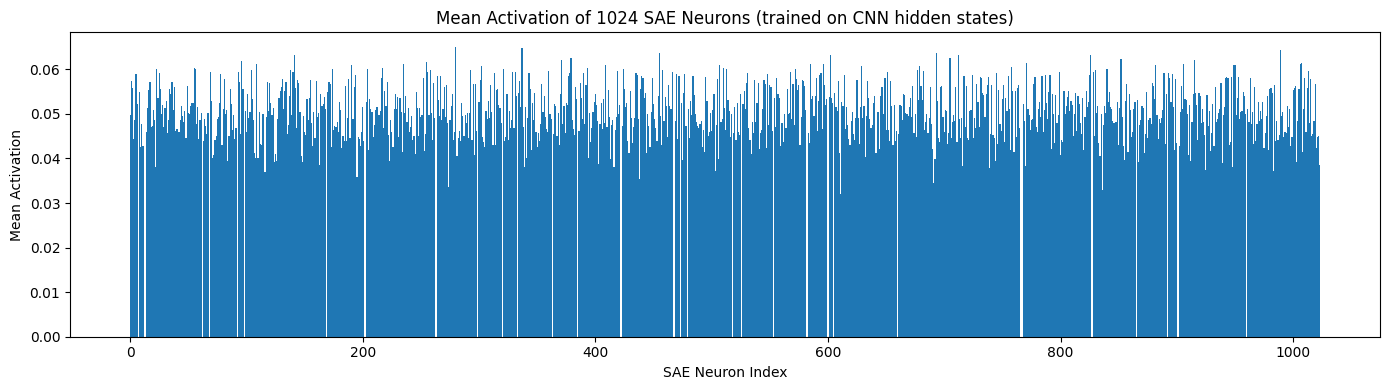

In [6]:
sae.eval()
with torch.no_grad():
    _, all_encoded = sae(H_easy_norm.to(device))
    mean_activation = all_encoded.mean(dim=0).cpu().numpy()

plt.figure(figsize=(14, 4))
plt.bar(range(hidden_dim), mean_activation, width=1.0)
plt.xlabel("SAE Neuron Index"); plt.ylabel("Mean Activation")
plt.title(f"Mean Activation of {hidden_dim} SAE Neurons (trained on CNN hidden states)")
plt.tight_layout(); plt.show()

In [7]:
torch.manual_seed(42)
INITIAL_NOISE = torch.randn(1, 3, 28, 28, device=device)

def probe_sae_neuron_via_cnn(sae_model, cnn_model, neuron_idx, init_noise,
                              iterations=500, lr=0.05):
    input_img = init_noise.clone().detach().requires_grad_(True)
    opt = optim.Adam([input_img], lr=lr)

    for _ in range(iterations):
        opt.zero_grad()
        x = F.relu(cnn_model.conv1(input_img))
        x = F.relu(cnn_model.conv2(x))
        x = F.relu(cnn_model.conv3(x))
        h = torch.flatten(x, 1)
        h_norm = (h - H_min) / (H_max - H_min + 1e-8)
        encoded = torch.relu(sae_model.encoder(h_norm))
        activation = encoded[0, neuron_idx]
        loss = -activation
        loss.backward()
        opt.step()
        input_img.data.clamp_(0, 1)
    return input_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()

top_k = 64
top_indices = np.argsort(mean_activation)[::-1][:top_k]

print(f"Probing top {top_k} most active SAE neurons (through CNN)...")
probed_images = {}
for count, idx in enumerate(top_indices):
    if count % 16 == 0:
        print(f"  → {count}/{top_k}")
    probed_images[idx] = probe_sae_neuron_via_cnn(
        sae, model, idx, INITIAL_NOISE, iterations=500, lr=0.05)
print("Done!")

Probing top 64 most active SAE neurons (through CNN)...
  → 0/64
  → 16/64
  → 32/64
  → 48/64
Done!


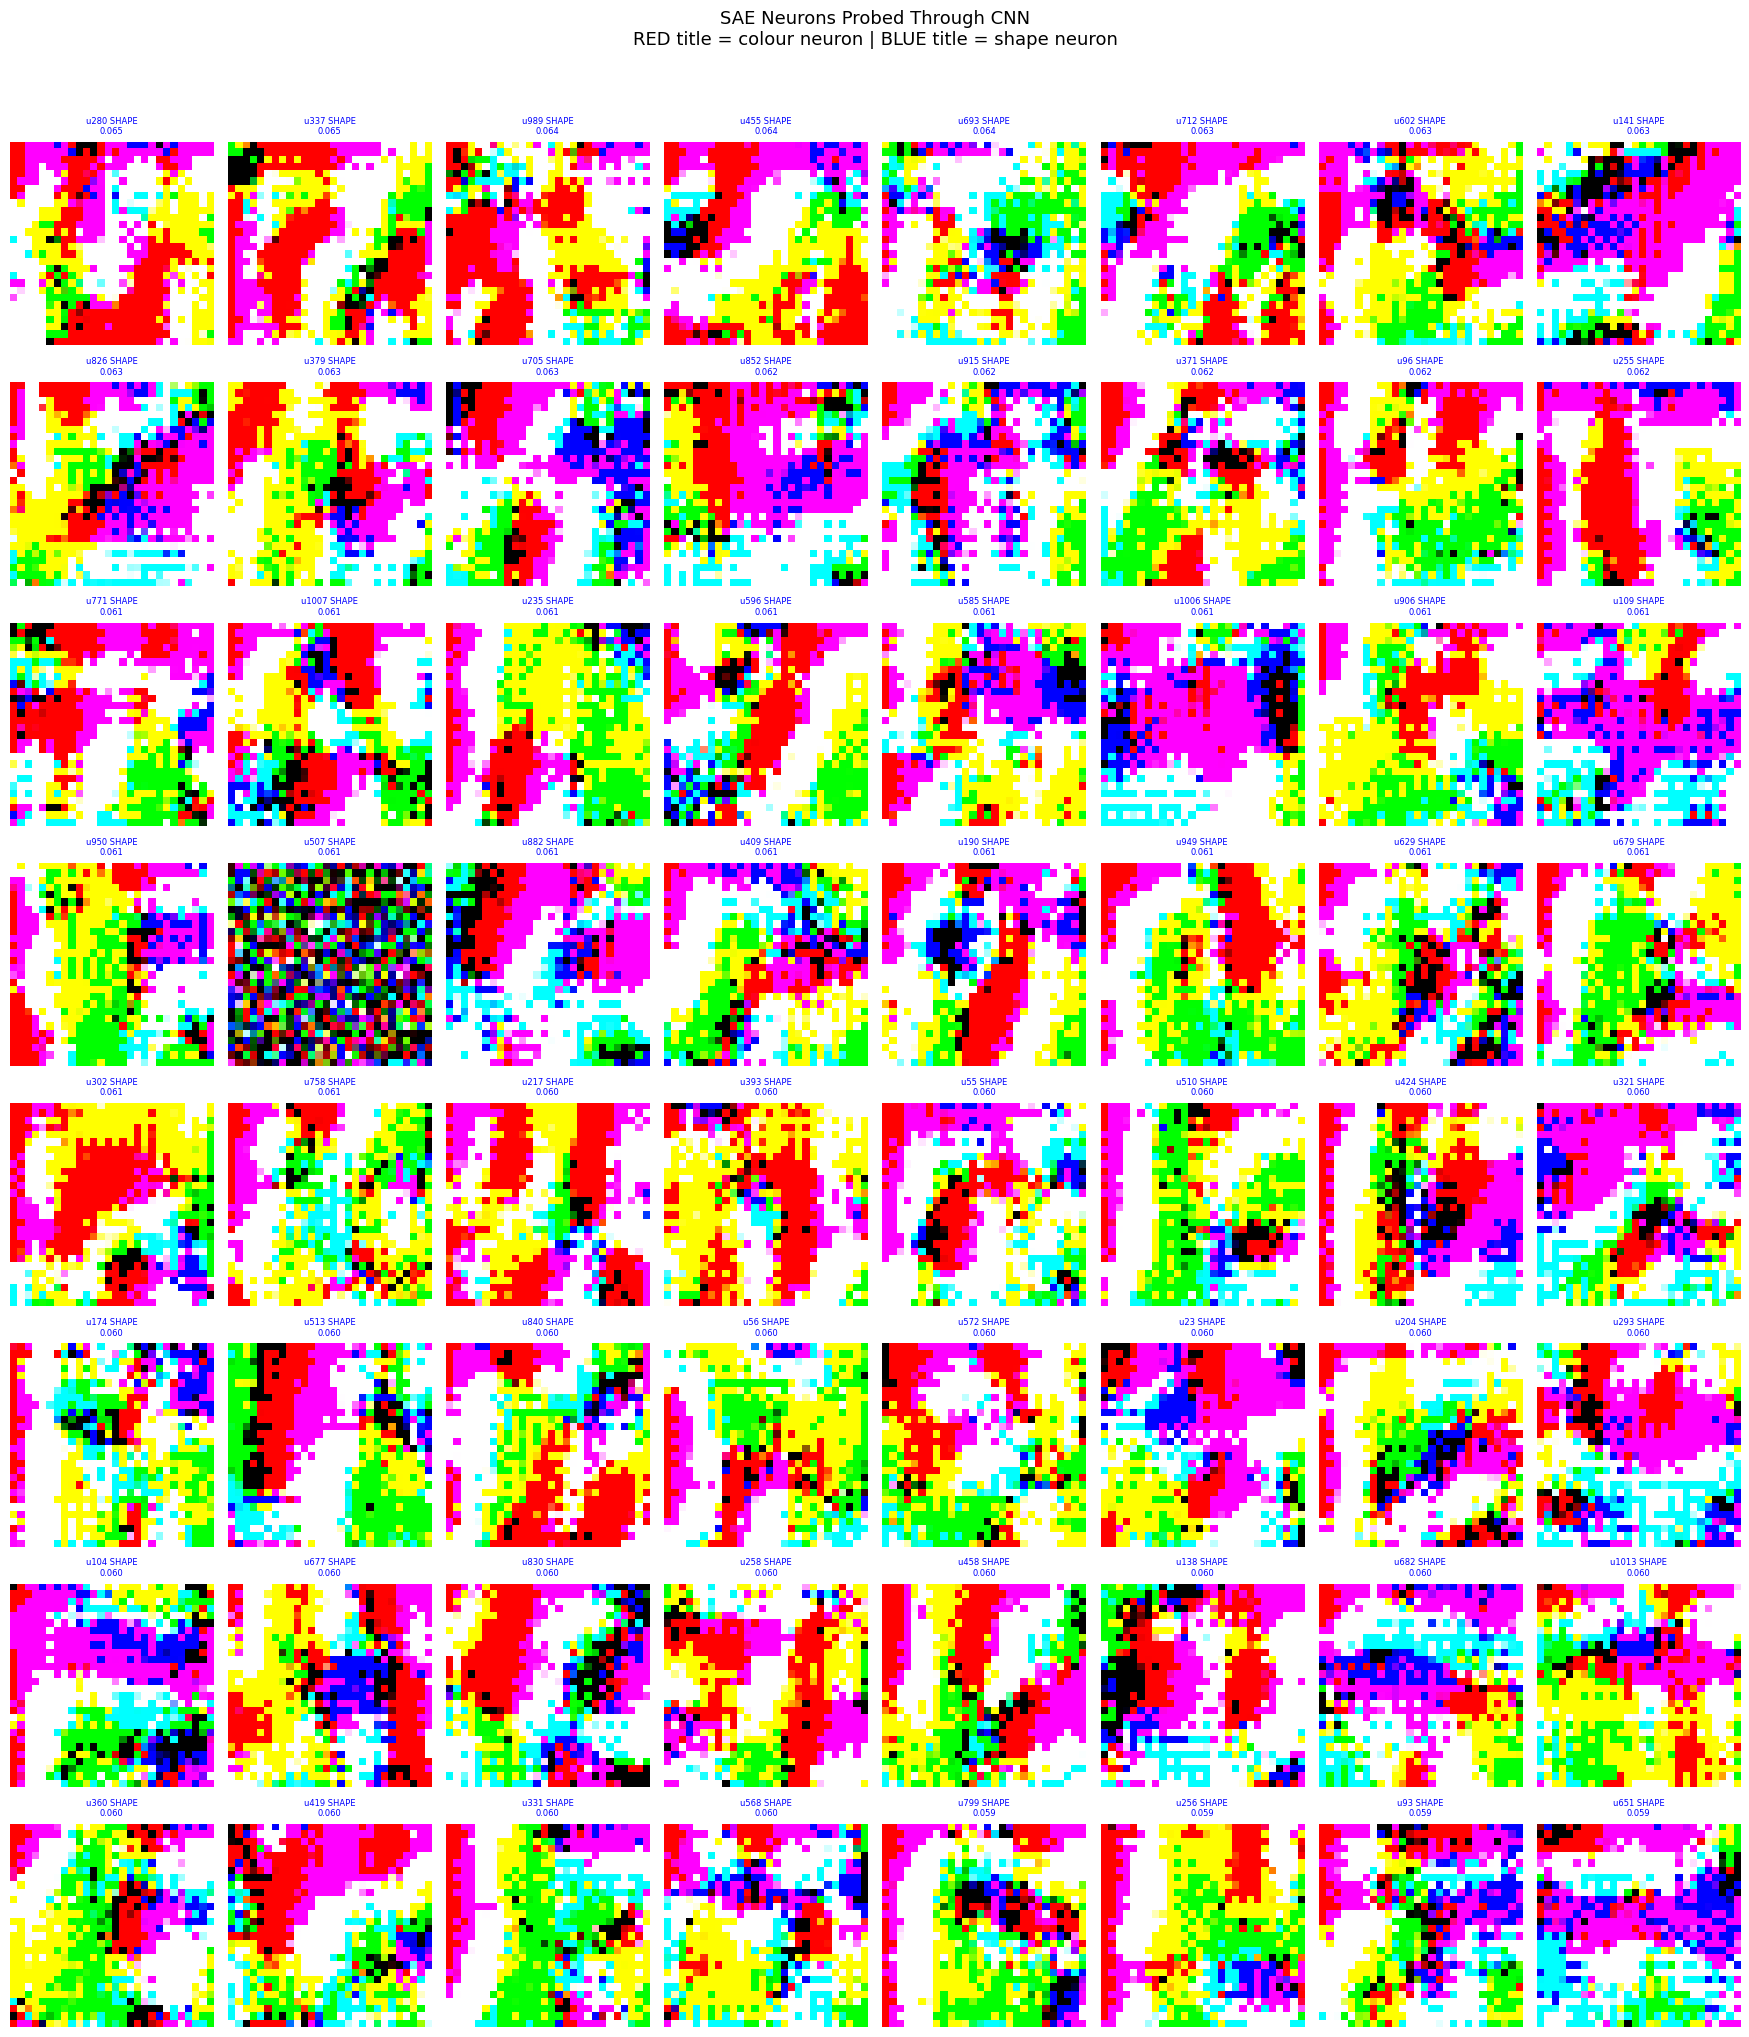


Colour neurons: 0 / 64
Shape neurons:  64 / 64


In [9]:
cols = 8
rows = (top_k + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.5))
colour_neurons, shape_neurons = [], []

for plot_i, idx in enumerate(top_indices):
    r, c = divmod(plot_i, cols)
    ax = axes[r, c]
    img = probed_images[idx]
    ax.imshow(img)
    std_spatial = img.std(axis=(0, 1)).mean()
    mean_rgb = img.mean(axis=(0, 1))
    ch_names = ["R", "G", "B"]
    dominant = ch_names[mean_rgb.argmax()]
    if std_spatial < 0.15:
        ntype = "COL"
        colour_neurons.append((idx, mean_activation[idx]))
        ax.set_title(f"u{idx} COL({dominant})\n{mean_activation[idx]:.3f}",
                      fontsize=6, color='red')
    else:
        ntype = "SHAPE"
        shape_neurons.append((idx, mean_activation[idx]))
        ax.set_title(f"u{idx} SHAPE\n{mean_activation[idx]:.3f}",
                      fontsize=6, color='blue')
    ax.axis('off')

for i in range(len(top_indices), rows * cols):
    r, c = divmod(i, cols)
    axes[r, c].axis('off')

fig.suptitle("SAE Neurons Probed Through CNN\n"
             "RED title = colour neuron | BLUE title = shape neuron",
             fontsize=13, y=1.02)
plt.tight_layout(); plt.show()

print(f"\nColour neurons: {len(colour_neurons)} / {top_k}")
print(f"Shape neurons:  {len(shape_neurons)} / {top_k}")

In [11]:
colour_neuron_indices = [idx for idx, _ in colour_neurons]
shape_neuron_indices  = [idx for idx, _ in shape_neurons]

@torch.no_grad()
def intervene_and_predict(H_norm, scale_colour=1.0, scale_shape=1.0, n_samples=500):
    H_in = H_norm[:n_samples].to(device)
    encoded = torch.relu(sae.encoder(H_in))
    for idx in colour_neuron_indices:
        encoded[:, idx] *= scale_colour
    for idx in shape_neuron_indices:
        encoded[:, idx] *= scale_shape
    H_modified = sae.decoder(encoded)
    H_real = H_modified * (H_max - H_min + 1e-8) + H_min
    logits = model.fc(H_real)
    preds  = logits.argmax(dim=1).cpu()
    return preds

n_test = min(500, len(H_easy_norm))
true_labels = Y_easy[:n_test]

preds_base = intervene_and_predict(H_easy_norm, scale_colour=1.0, scale_shape=1.0, n_samples=n_test)
acc_base = (preds_base == true_labels).float().mean().item()

preds_no_colour = intervene_and_predict(H_easy_norm, scale_colour=0.0, scale_shape=1.0, n_samples=n_test)
acc_no_colour = (preds_no_colour == true_labels).float().mean().item()

preds_boost_colour = intervene_and_predict(H_easy_norm, scale_colour=3.0, scale_shape=1.0, n_samples=n_test)
acc_boost_colour = (preds_boost_colour == true_labels).float().mean().item()

preds_no_shape = intervene_and_predict(H_easy_norm, scale_colour=1.0, scale_shape=0.0, n_samples=n_test)
acc_no_shape = (preds_no_shape == true_labels).float().mean().item()

print("=" * 60)
print("INTERVENTION RESULTS (Easy Set)")
print("=" * 60)
print(f"  Baseline (no change):       {acc_base:.3f}")
print(f"  Kill colour neurons (×0):   {acc_no_colour:.3f}")
print(f"  Boost colour neurons (×3):  {acc_boost_colour:.3f}")
print(f"  Kill shape neurons (×0):    {acc_no_shape:.3f}")

INTERVENTION RESULTS (Easy Set)
  Baseline (no change):       0.946
  Kill colour neurons (×0):   0.946
  Boost colour neurons (×3):  0.946
  Kill shape neurons (×0):    0.924


In [12]:
n_test_hard = min(500, len(H_hard_norm))
true_labels_hard = Y_hard[:n_test_hard]

preds_hard_base = intervene_and_predict(H_hard_norm, 1.0, 1.0, n_test_hard)
acc_hard_base = (preds_hard_base == true_labels_hard).float().mean().item()

preds_hard_no_colour = intervene_and_predict(H_hard_norm, 0.0, 1.0, n_test_hard)
acc_hard_no_colour = (preds_hard_no_colour == true_labels_hard).float().mean().item()

preds_hard_boost_shape = intervene_and_predict(H_hard_norm, 0.0, 3.0, n_test_hard)
acc_hard_boost_shape = (preds_hard_boost_shape == true_labels_hard).float().mean().item()

print("=" * 60)
print("INTERVENTION RESULTS (Hard Set)")
print("=" * 60)
print(f"  Baseline:                    {acc_hard_base:.3f}")
print(f"  Kill colour neurons (×0):    {acc_hard_no_colour:.3f}")
print(f"  Kill colour + boost shape:   {acc_hard_boost_shape:.3f}")

INTERVENTION RESULTS (Hard Set)
  Baseline:                    0.110
  Kill colour neurons (×0):    0.110
  Kill colour + boost shape:   0.130
